In [25]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from sklearn.decomposition import PCA

In [26]:
import seaborn as sns
import numpy as np
import pandas as pd
import pandas_gbq as pd_gbq
import gc
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from matplotlib import pyplot as plt
from google.cloud import bigquery
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.preprocessing import StandardScaler
import pickle
from tqdm.auto import tqdm
import pyarrow as pa
import pyarrow.parquet as pq
import joblib
import glob
import lightgbm as lgb
from google.cloud import storage
from pandas_profiling import ProfileReport
#from pyspark.context import SparkContext
#from pyspark.ml.linalg import Vectors
#from pyspark.ml.regression import LinearRegression
#from pyspark.sql.session import SparkSession

%reload_ext google.cloud.bigquery


In [27]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage before optimization is: {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


#Train data
bqclient = bigquery.Client()

query_string = """
SELECT * FROM `crack-petal-363512.Amex.Train`
"""

#select a.*,b.target from
#(SELECT * FROM `amexcds4.amextaiwan.amextaiwantrain`) a
#left join
#(SELECT * FROM `amexcds4.amextaiwan.trainLabels`) b
#on a.customer_ID	 = b.customer_ID;

train_all_df = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)


In [28]:
#Train label
bqclient = bigquery.Client()

query_string = """
SELECT * FROM `crack-petal-363512.Amex.Train_Label`
"""

dataframe_labels = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)

In [29]:
# Reduce memory
train_all_df=reduce_mem_usage(train_all_df)
gc.collect()

Memory usage before optimization is: 8018.31 MB
Memory usage after optimization is: 2125.91 MB
Decreased by 73.5%


426

In [30]:
train_df = pd.merge(train_all_df, dataframe_labels, how='left', on='customer_ID')


In [31]:
train_df[["S_2_year", "S_2_month", "S_2_day"]] = train_df['S_2'].str.split("-", expand = True)
train_df['S_2_day'] = train_df['S_2_day'].astype(int)
train_df['S_2_month'] = train_df['S_2_month'].astype(int)
train_df['S_2_year'] = train_df['S_2_year'].astype(int)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


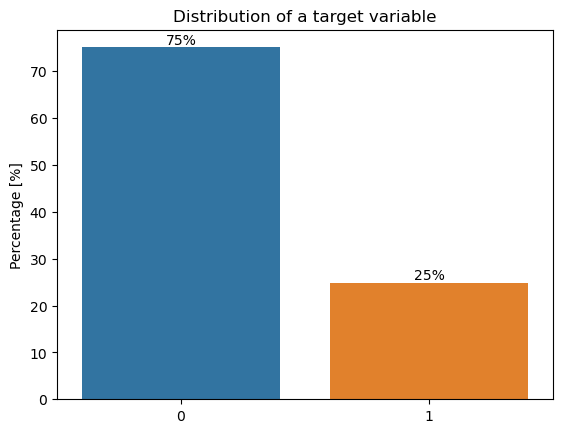

In [32]:
tmp = train_df['target'].value_counts().div(len(train_df)).mul(100)
ax = sns.barplot(x=tmp.index, y=tmp.values)
ax.bar_label(ax.containers[0], fmt='%.f%%')
plt.title("Distribution of a target variable")
plt.ylabel("Percentage [%]")
plt.show()

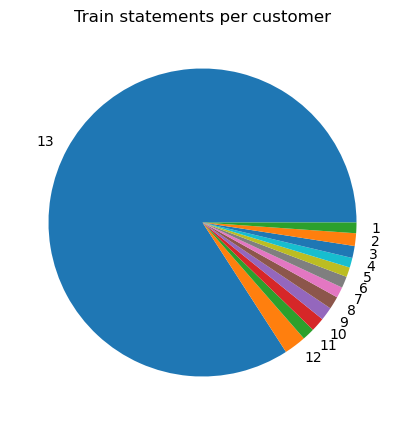

In [33]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 5))
train_sc = train_df.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Train statements per customer')
ax1.pie(train_sc, labels=train_sc.index)
ax1.set_title(train_sc.name)
plt.show()

In [34]:
stat_plot = train_df.reset_index().groupby('S_2')['customer_ID'].nunique().reset_index()
stat_plot

S_2  customer_ID
0    2017-03-01        10381
1    2017-03-02         8952
2    2017-03-03        13635
3    2017-03-04        14463
4    2017-03-05         7879
..          ...          ...
391  2018-03-27        15457
392  2018-03-28        17263
393  2018-03-29        14414
394  2018-03-30        17293
395  2018-03-31         9836

[396 rows x 2 columns]

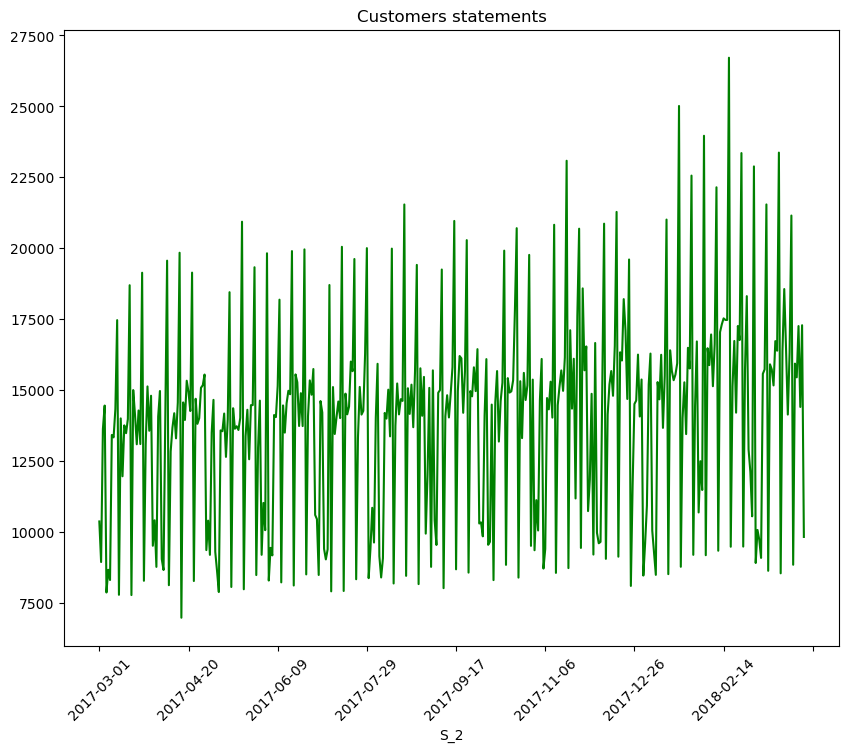

In [35]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
ax.set_title('Customers statements')
stat_plot.set_index('S_2')['customer_ID'].plot(ax=ax, color='green')
plt.xticks(rotation=45)
plt.savefig('cust_statements.png')
plt.show()

In [36]:
stat_plot = train_df.reset_index().groupby(['S_2', 'target'])['P_2'].sum().reset_index()
stat_plot

S_2  target     P_2
0    2017-03-01       0  5728.0
1    2017-03-01       1  1095.0
2    2017-03-02       0  4940.0
3    2017-03-02       1   992.5
4    2017-03-03       0  8024.0
..          ...     ...     ...
787  2018-03-29       1  1115.0
788  2018-03-30       0  9136.0
789  2018-03-30       1  1515.0
790  2018-03-31       0  5272.0
791  2018-03-31       1   871.0

[792 rows x 3 columns]

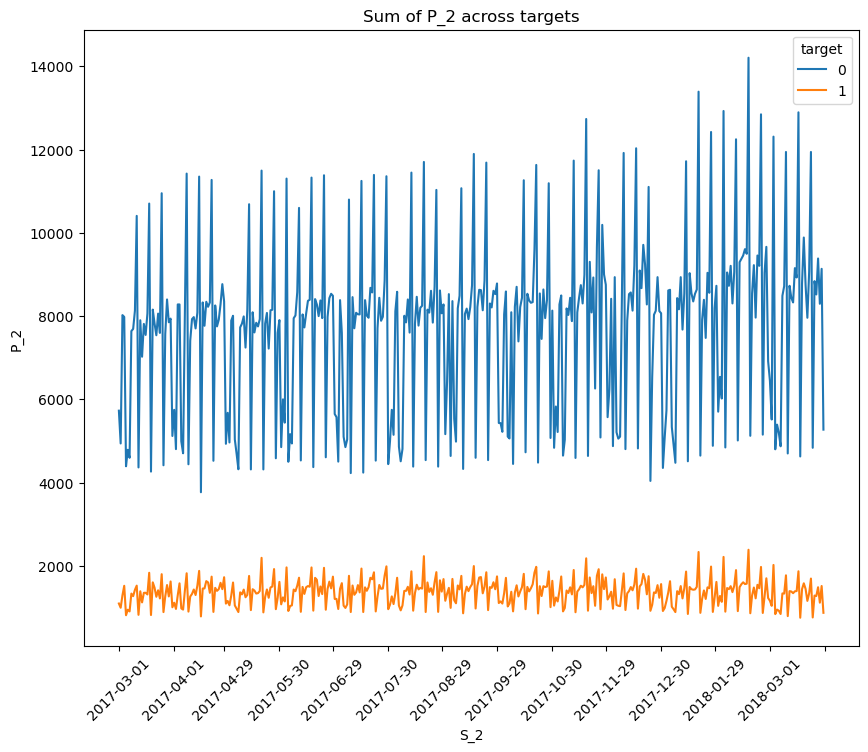

In [37]:
import matplotlib.dates as mdates

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
ax.set_title('Sum of P_2 across targets')
sns.lineplot(data=stat_plot, x='S_2', y='P_2', hue='target')
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  This is separate from the ipykernel package so we can avoid doing imports until


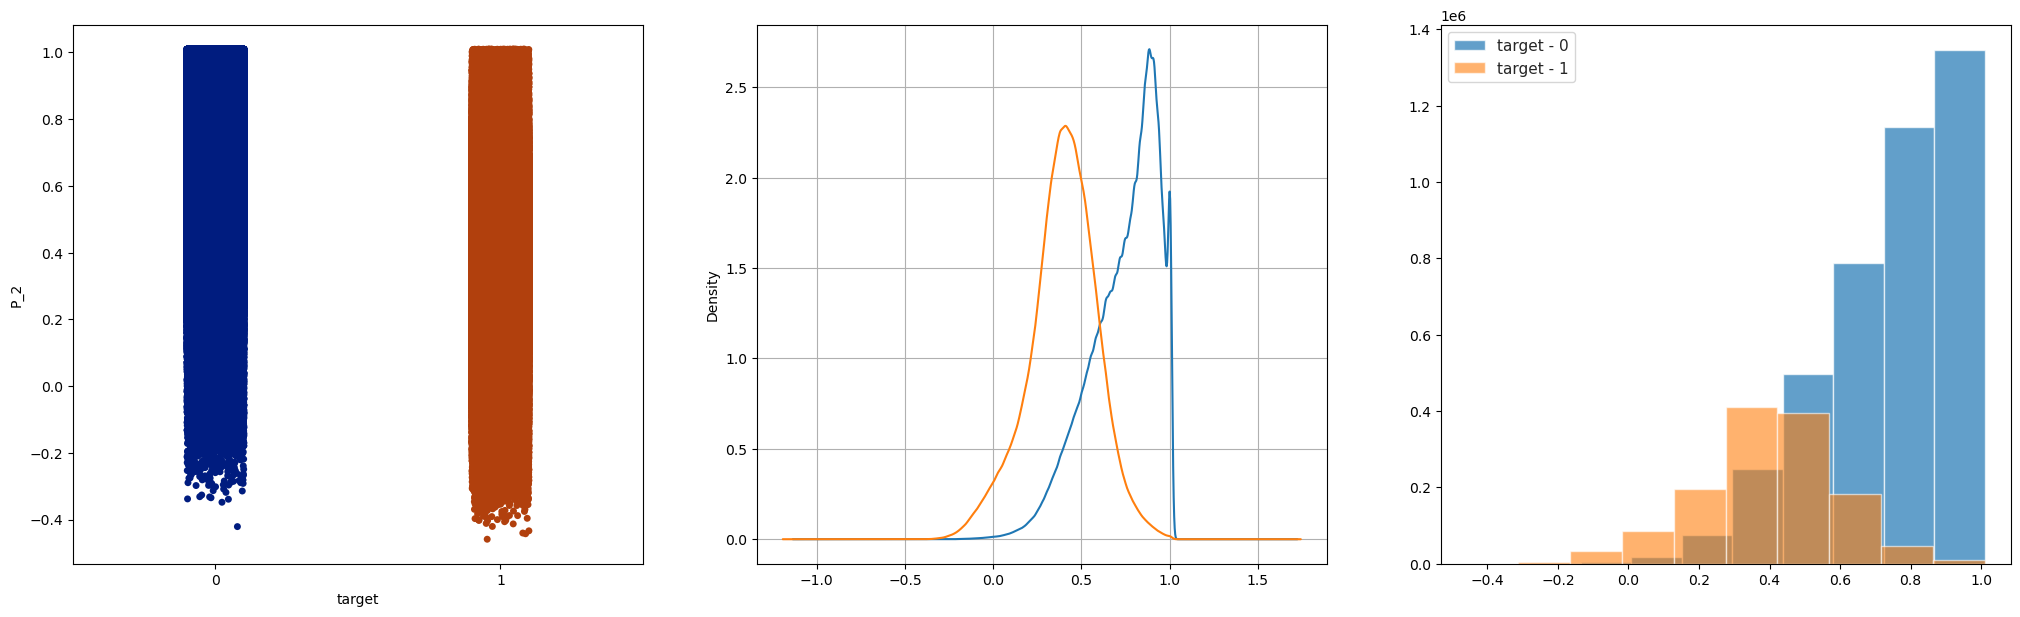

In [38]:
f, ax = plt.subplots(nrows=1, ncols=3,figsize=(25, 7))
sns.set_theme(style="whitegrid")
sns.stripplot(data=train_df, x='target', y='P_2', palette="dark", ax=ax[0])

train_df.groupby('target').P_2.plot(kind='kde', ax=ax[1])

sliced_data = train_df[['target', 'P_2']]
P2_0 = sliced_data[sliced_data['target']==0]
P2_1 = sliced_data[sliced_data['target']==1]
plt.hist(P2_0['P_2'], alpha=0.7, label="target - 0")
plt.hist(P2_1['P_2'], alpha=0.6, label="target - 1")
ax[2].legend()

plt.show()

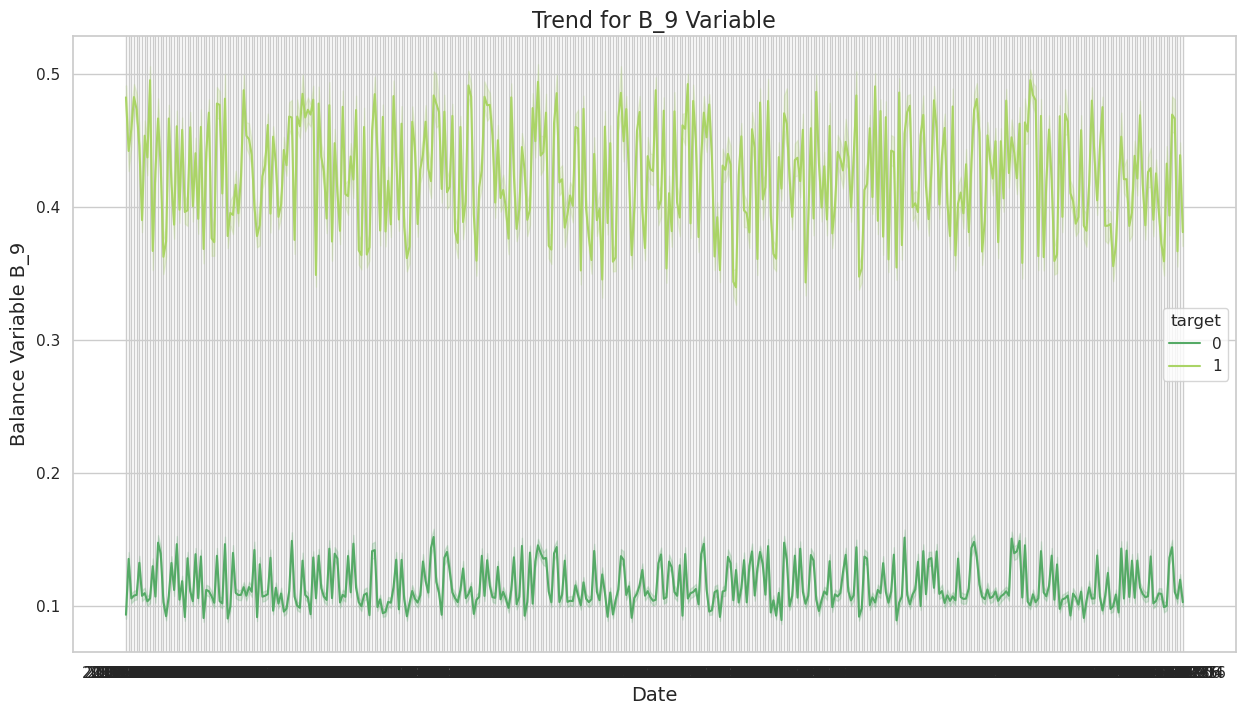

In [39]:
# trend for B_9 variable
plt.figure(figsize=(15,8))
sns.lineplot(data = train_df, x = 'S_2', y = 'B_9', hue= 'target', palette='summer')
plt.xlabel('Date', size = 14)
plt.ylabel('Balance Variable B_9', size = 14)
plt.title('Trend for B_9 Variable', size = 16)
plt.grid(visible = True, axis = 'y')
plt.show()

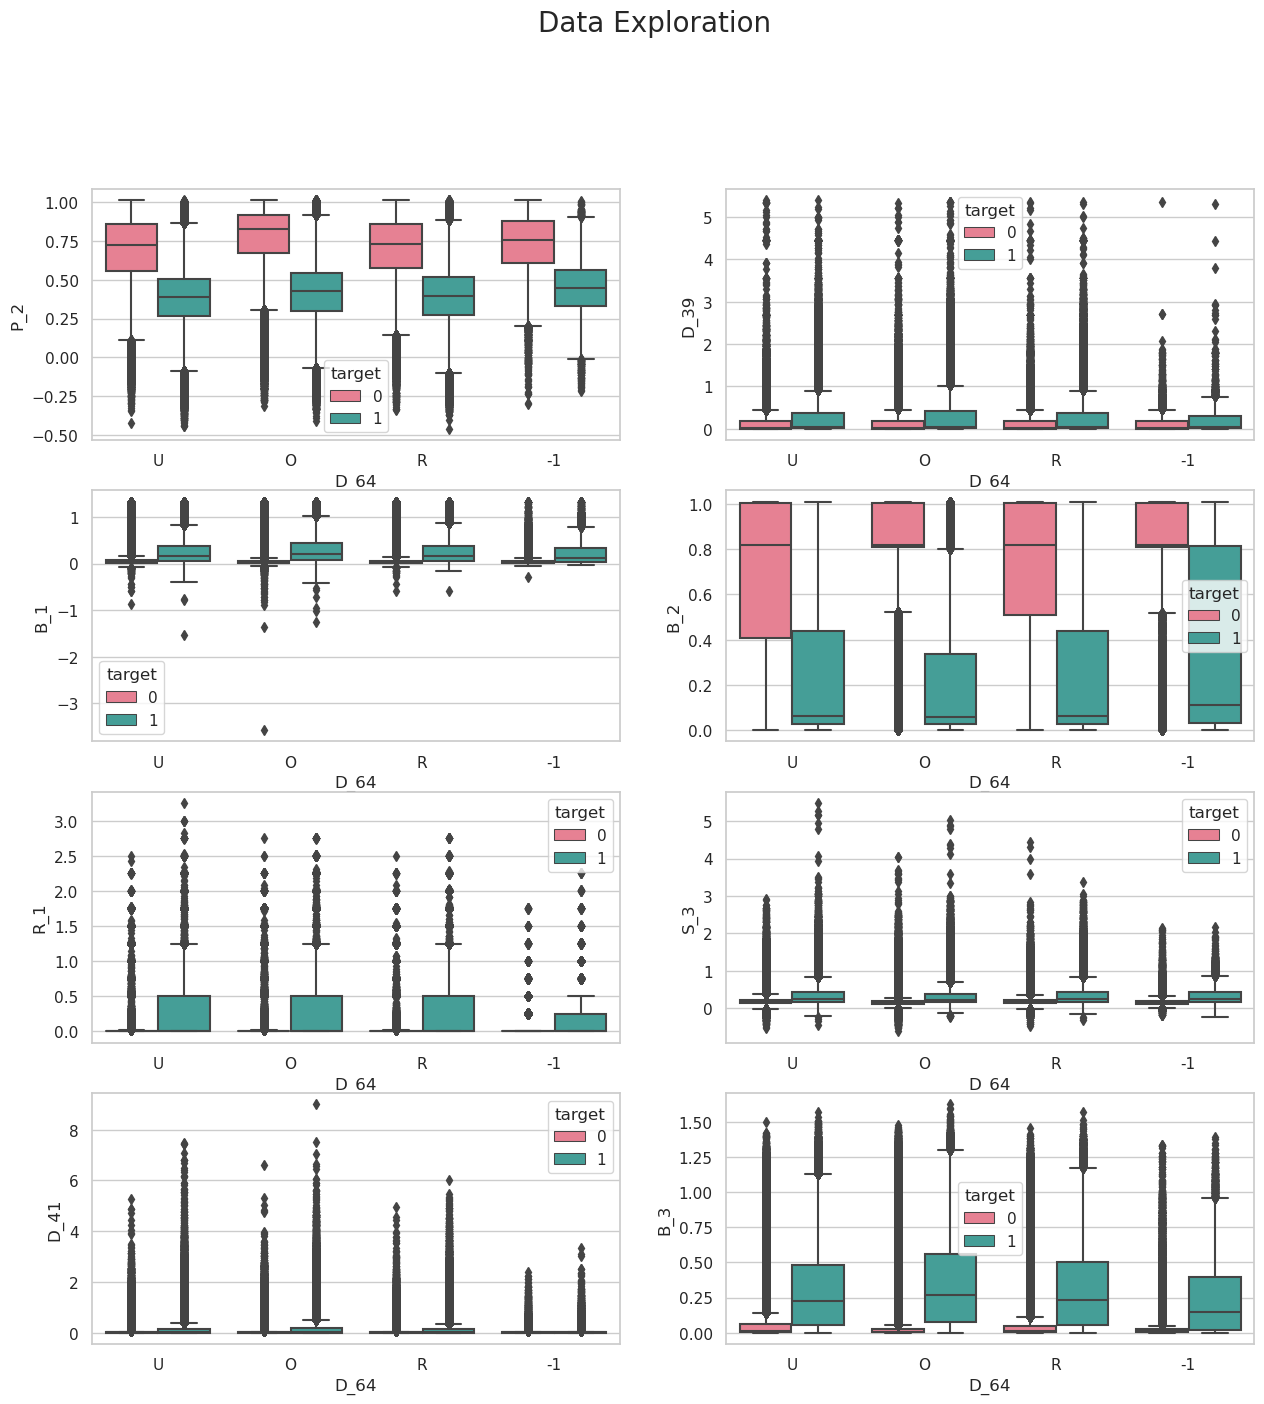

In [40]:
f, ax = plt.subplots(nrows=4, ncols=2,figsize=(15,15))

sns.boxplot(data=train_df, y='P_2', x='D_64', hue='target', ax=ax[0][0], palette="husl")
sns.boxplot(data=train_df, y='D_39', x='D_64', hue='target', ax=ax[0][1], palette="husl")
sns.boxplot(data=train_df, y='B_1', x='D_64', hue='target', ax=ax[1][0], palette="husl")
sns.boxplot(data=train_df, y='B_2', x='D_64', hue='target', ax=ax[1][1], palette="husl")
sns.boxplot(data=train_df, y='R_1', x='D_64', hue='target', ax=ax[2][0], palette="husl")
sns.boxplot(data=train_df, y='S_3', x='D_64', hue='target', ax=ax[2][1], palette="husl")
sns.boxplot(data=train_df, y='D_41', x='D_64', hue='target', ax=ax[3][0], palette="husl")
sns.boxplot(data=train_df, y='B_3', x='D_64', hue='target', ax=ax[3][1], palette="husl")
f.suptitle('Data Exploration', fontsize = 20, x = 0.5, y = 1)
plt.savefig('eda1.png')
plt.show()

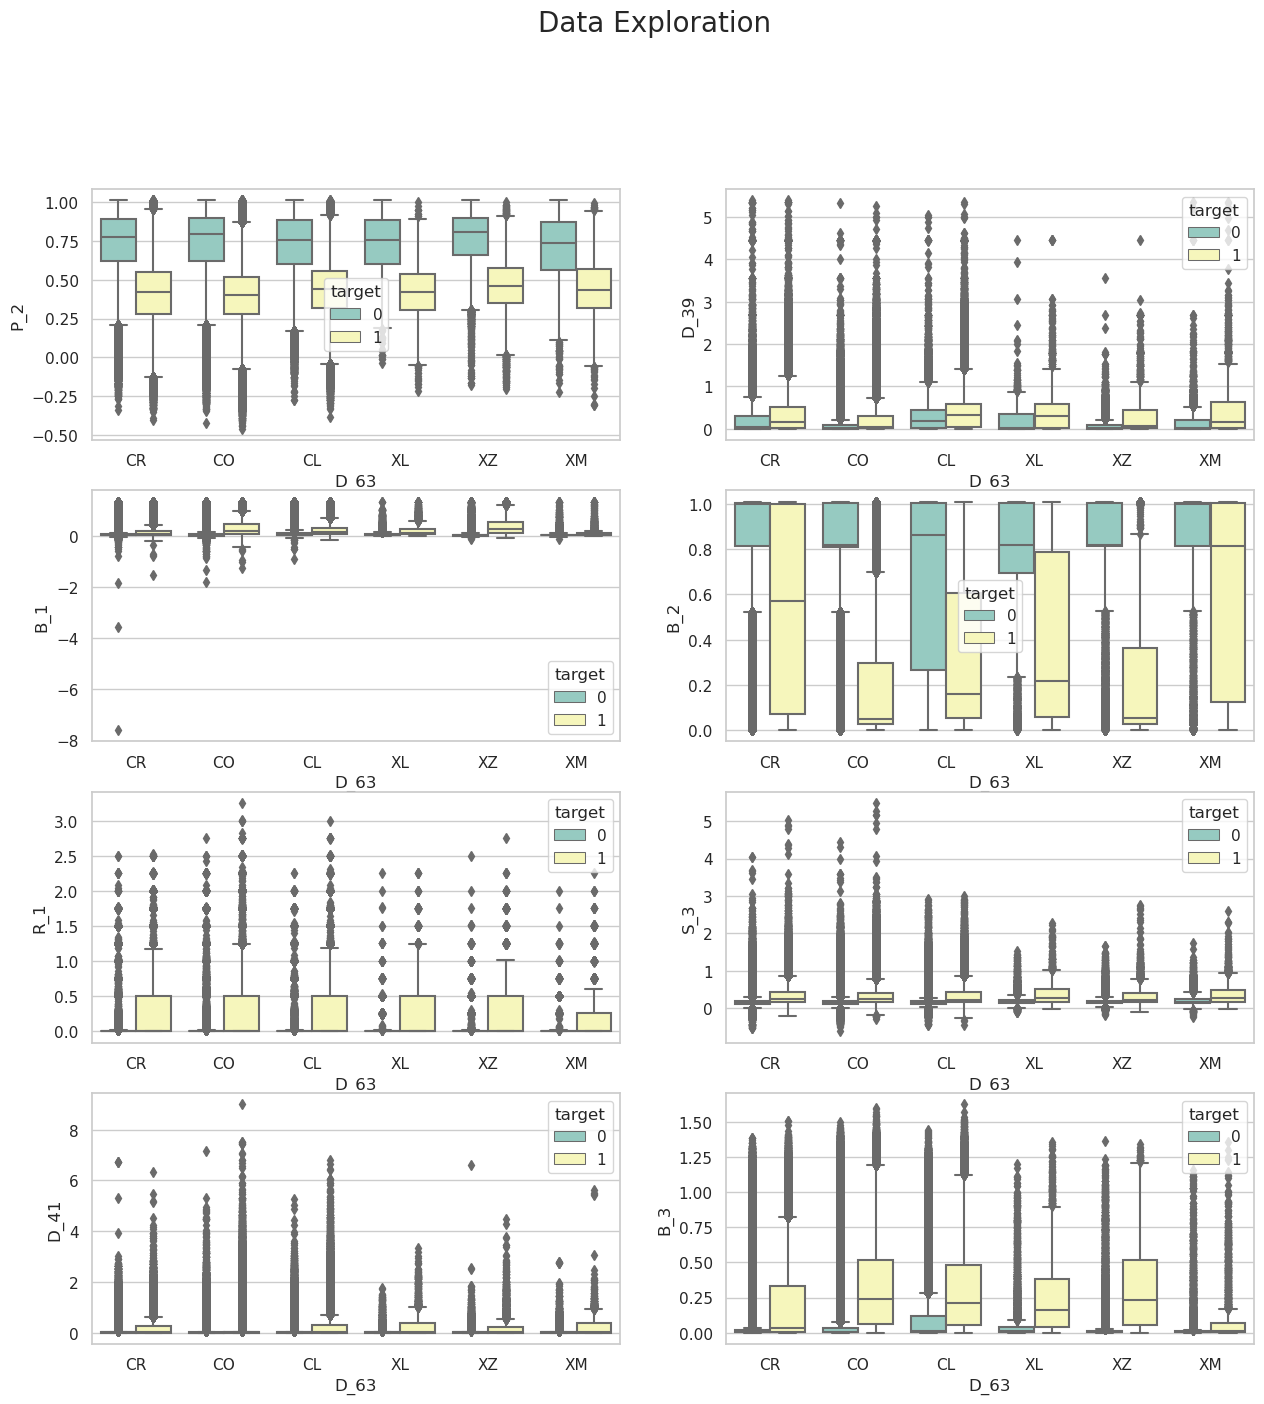

In [41]:
f, ax = plt.subplots(nrows=4, ncols=2,figsize=(15,15))

sns.boxplot(data=train_df, y='P_2', x='D_63', hue='target', ax=ax[0][0], palette="Set3")
sns.boxplot(data=train_df, y='D_39', x='D_63', hue='target', ax=ax[0][1], palette="Set3")
sns.boxplot(data=train_df, y='B_1', x='D_63', hue='target', ax=ax[1][0], palette="Set3")
sns.boxplot(data=train_df, y='B_2', x='D_63', hue='target', ax=ax[1][1], palette="Set3")
sns.boxplot(data=train_df, y='R_1', x='D_63', hue='target', ax=ax[2][0], palette="Set3")
sns.boxplot(data=train_df, y='S_3', x='D_63', hue='target', ax=ax[2][1], palette="Set3")
sns.boxplot(data=train_df, y='D_41', x='D_63', hue='target', ax=ax[3][0], palette="Set3")
sns.boxplot(data=train_df, y='B_3', x='D_63', hue='target', ax=ax[3][1], palette="Set3")
f.suptitle('Data Exploration', fontsize = 20, x = 0.5, y = 1)
plt.savefig('eda1.png')
plt.show()

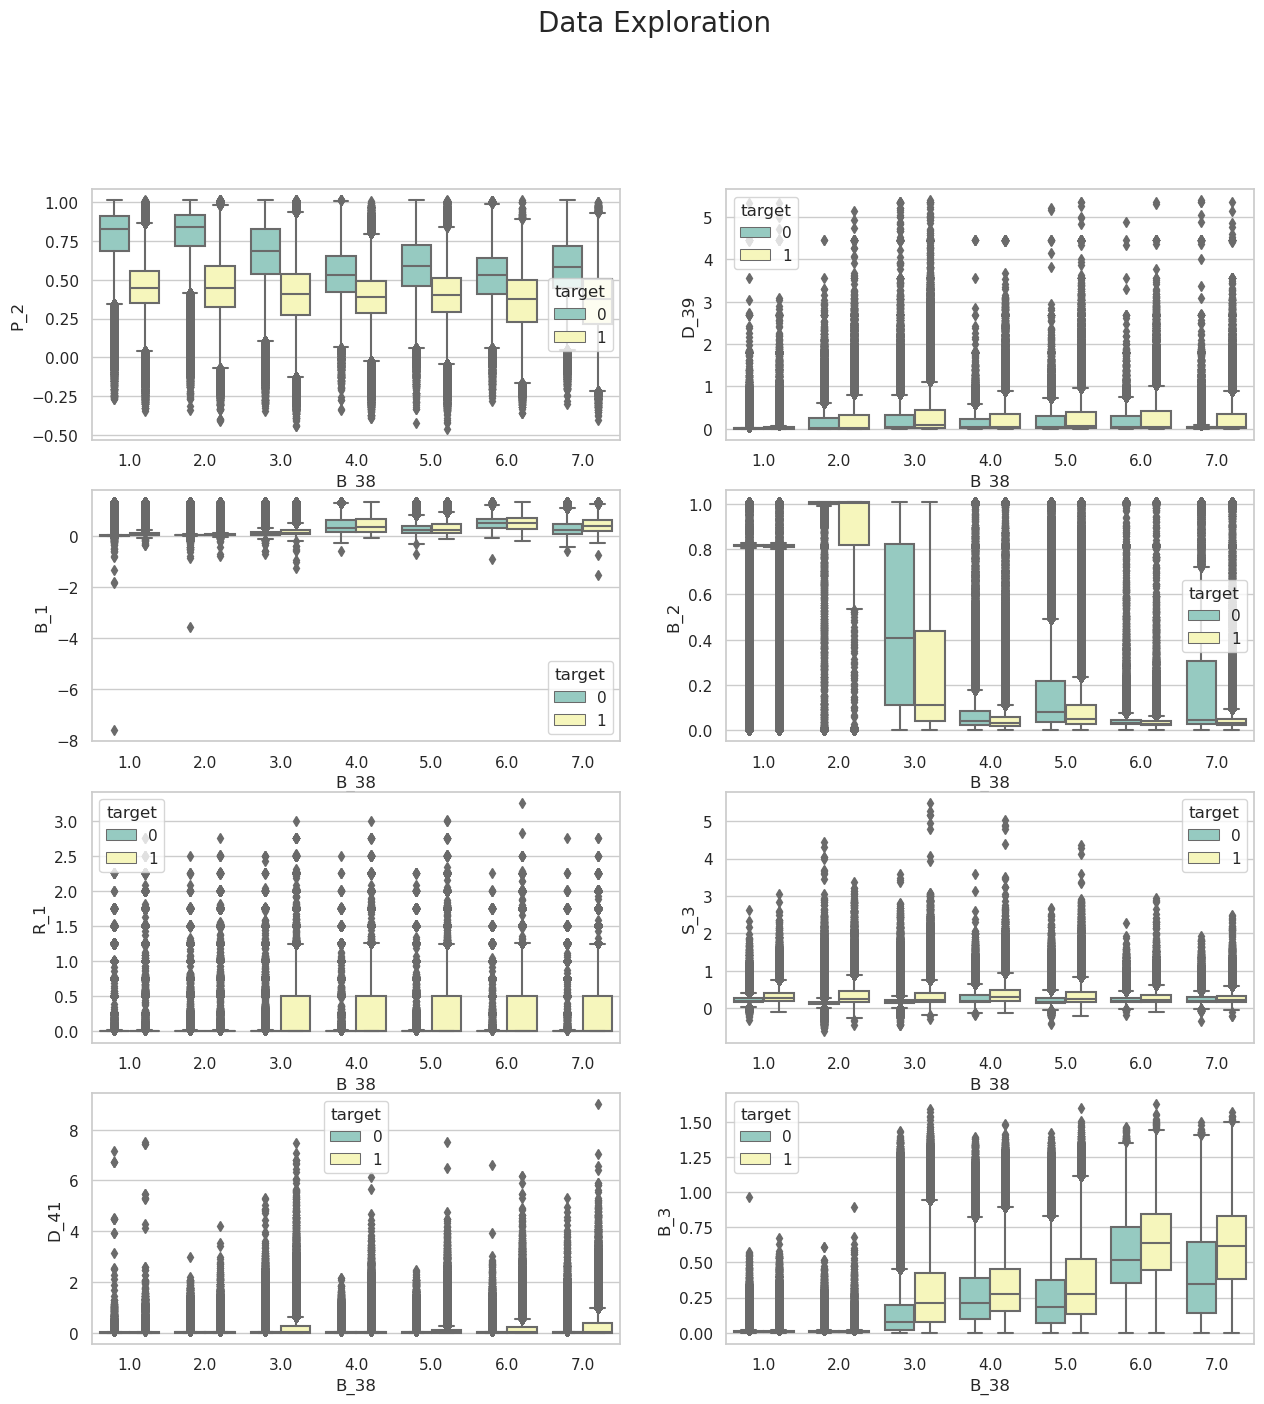

In [47]:
f, ax = plt.subplots(nrows=4, ncols=2,figsize=(15,15))

sns.boxplot(data=train_df, y='P_2', x='B_38', hue='target', ax=ax[0][0], palette="Set3")
sns.boxplot(data=train_df, y='D_39', x='B_38', hue='target', ax=ax[0][1], palette="Set3")
sns.boxplot(data=train_df, y='B_1', x='B_38', hue='target', ax=ax[1][0], palette="Set3")
sns.boxplot(data=train_df, y='B_2', x='B_38', hue='target', ax=ax[1][1], palette="Set3")
sns.boxplot(data=train_df, y='R_1', x='B_38', hue='target', ax=ax[2][0], palette="Set3")
sns.boxplot(data=train_df, y='S_3', x='B_38', hue='target', ax=ax[2][1], palette="Set3")
sns.boxplot(data=train_df, y='D_41', x='B_38', hue='target', ax=ax[3][0], palette="Set3")
sns.boxplot(data=train_df, y='B_3', x='B_38', hue='target', ax=ax[3][1], palette="Set3")
f.suptitle('Data Exploration', fontsize = 20, x = 0.5, y = 1)
plt.savefig('eda1.png')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


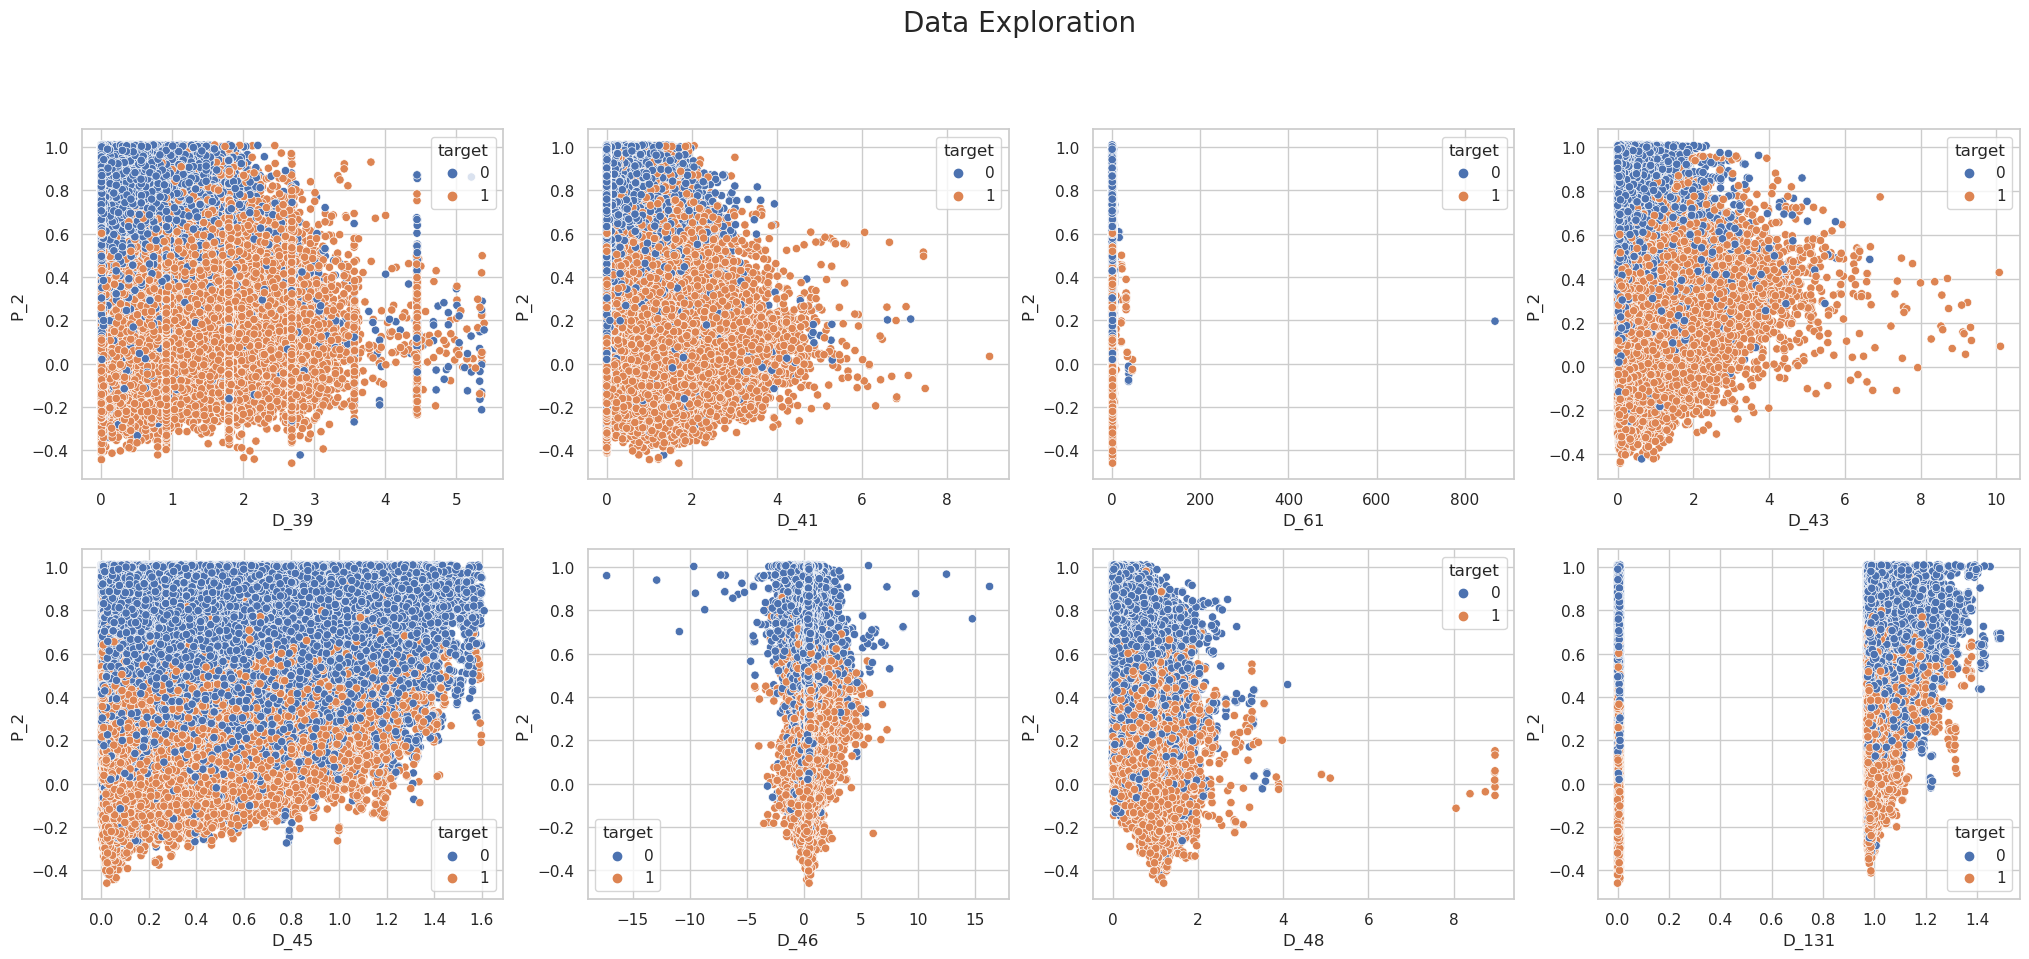

In [48]:
f, ax = plt.subplots(nrows=2, ncols=4,figsize=(25,10))
sns.scatterplot(data=train_df, x='D_39', y='P_2', hue='target', ax=ax[0][0], palette="deep")
sns.scatterplot(data=train_df, x='D_41', y='P_2',hue='target', ax=ax[0][1], palette="deep")
sns.scatterplot(data=train_df, x='D_61', y='P_2',hue='target', ax=ax[0][2], palette="deep")
sns.scatterplot(data=train_df, x='D_43',  y='P_2',hue='target', ax=ax[0][3], palette="deep")
sns.scatterplot(data=train_df, x='D_45', y='P_2', hue='target', ax=ax[1][0], palette="deep")
sns.scatterplot(data=train_df, x='D_46', y='P_2',hue='target', ax=ax[1][1], palette="deep")
sns.scatterplot(data=train_df, x='D_48', y='P_2',hue='target', ax=ax[1][2], palette="deep")
sns.scatterplot(data=train_df, x='D_131',  y='P_2',hue='target', ax=ax[1][3], palette="deep")
f.suptitle('Data Exploration', fontsize = 20, x = 0.5, y = 1)
plt.savefig('eda2.png')
plt.show()

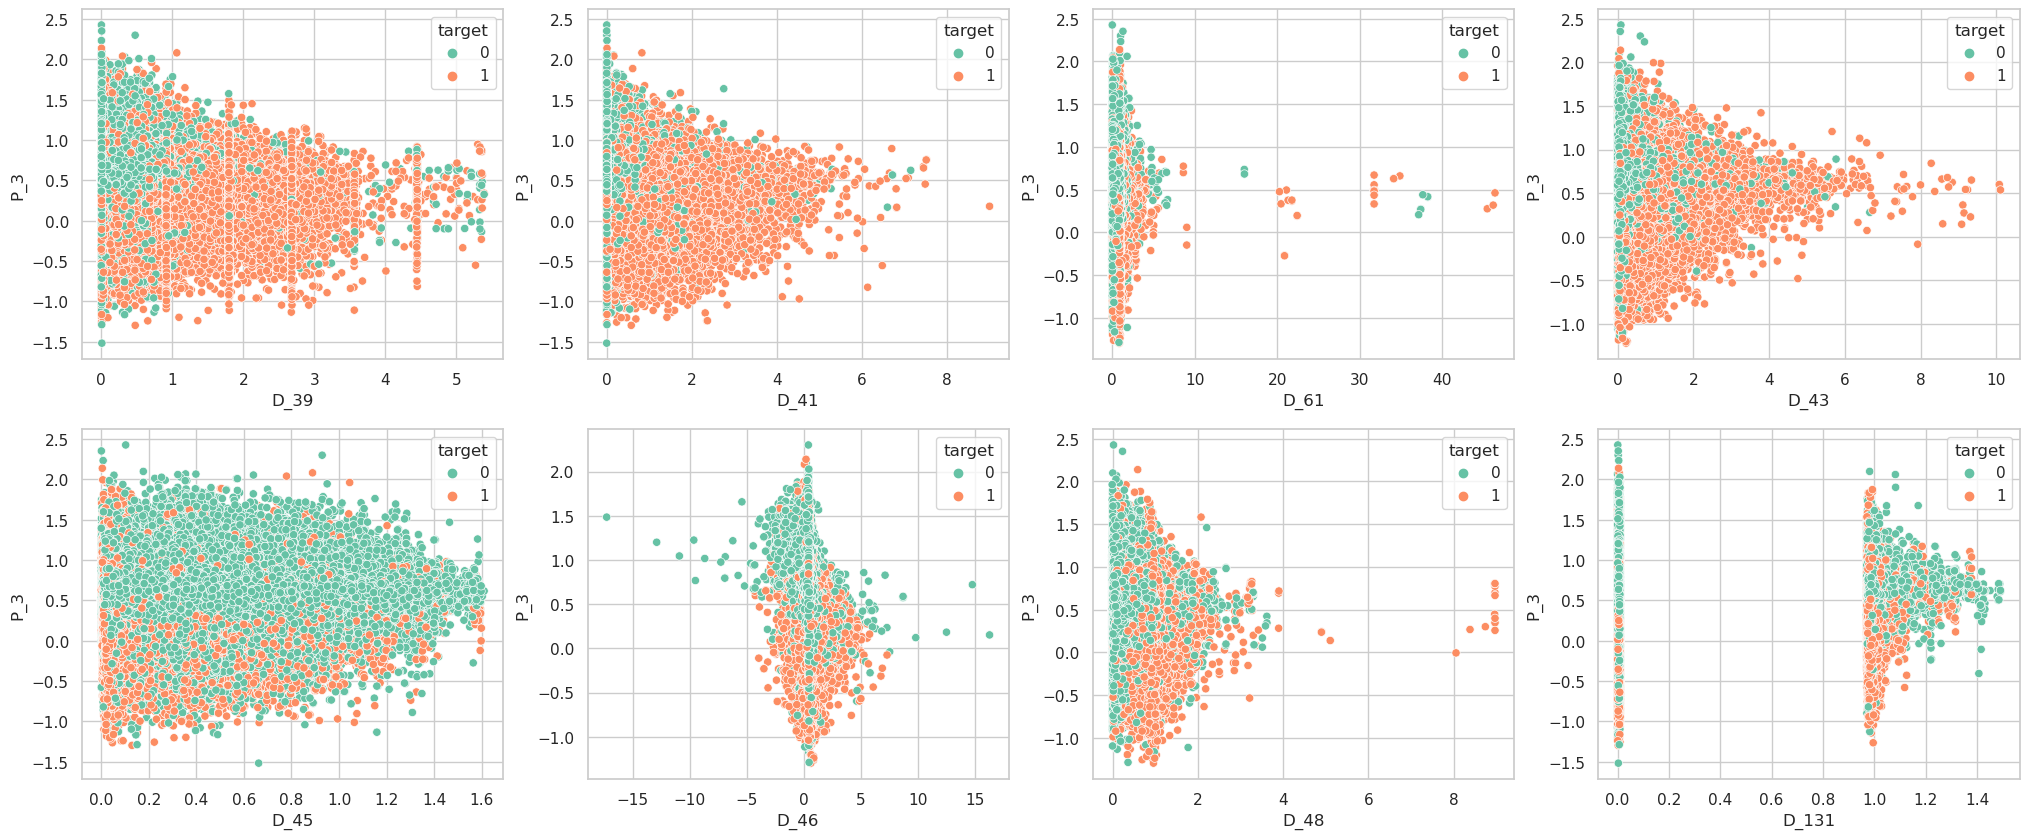

In [44]:
f, ax = plt.subplots(nrows=2, ncols=4,figsize=(25,10))
sns.scatterplot(data=train_df, x='D_39', y='P_3', hue='target', ax=ax[0][0], palette="Set2")
sns.scatterplot(data=train_df, x='D_41', y='P_3',hue='target', ax=ax[0][1], palette="Set2")
sns.scatterplot(data=train_df, x='D_61', y='P_3',hue='target', ax=ax[0][2], palette="Set2")
sns.scatterplot(data=train_df, x='D_43',  y='P_3',hue='target', ax=ax[0][3], palette="Set2")
sns.scatterplot(data=train_df, x='D_45', y='P_3', hue='target', ax=ax[1][0], palette="Set2")
sns.scatterplot(data=train_df, x='D_46', y='P_3',hue='target', ax=ax[1][1], palette="Set2")
sns.scatterplot(data=train_df, x='D_48', y='P_3',hue='target', ax=ax[1][2], palette="Set2")
sns.scatterplot(data=train_df, x='D_131',  y='P_3',hue='target', ax=ax[1][3], palette="Set2")
plt.show()

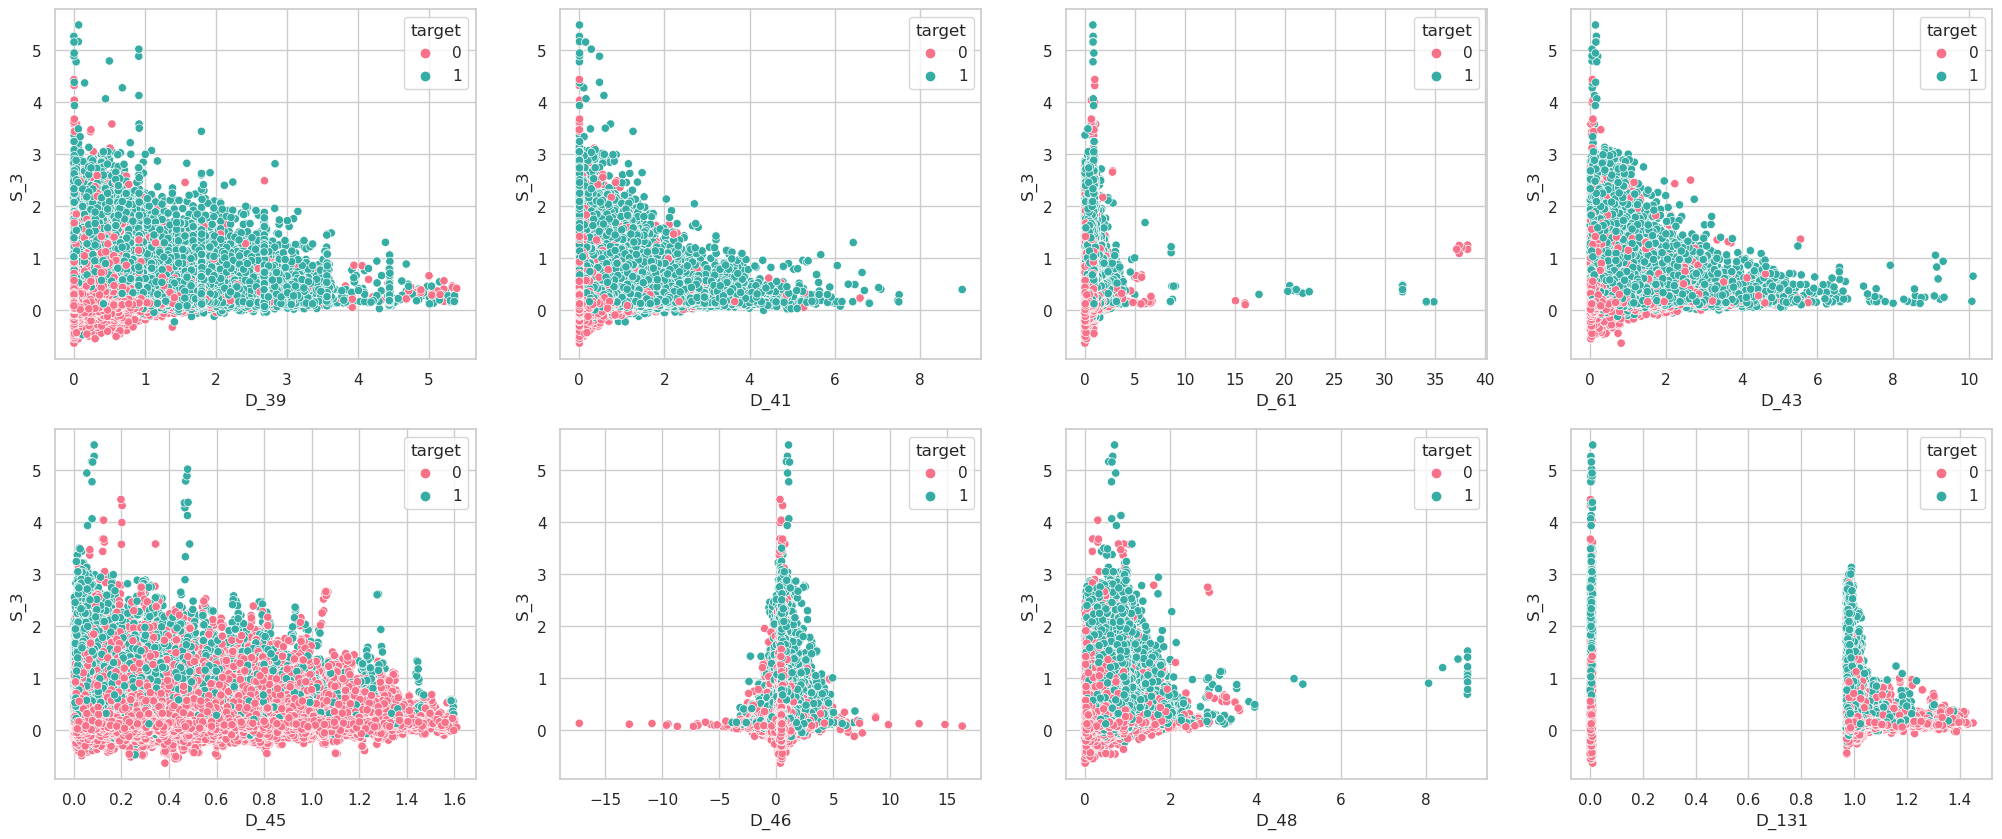

In [45]:
f, ax = plt.subplots(nrows=2, ncols=4,figsize=(25,10))
sns.scatterplot(data=train_df, x='D_39', y='S_3', hue='target', ax=ax[0][0], palette="husl")
sns.scatterplot(data=train_df, x='D_41', y='S_3',hue='target', ax=ax[0][1], palette="husl")
sns.scatterplot(data=train_df, x='D_61', y='S_3',hue='target', ax=ax[0][2], palette="husl")
sns.scatterplot(data=train_df, x='D_43',  y='S_3',hue='target', ax=ax[0][3], palette="husl")
sns.scatterplot(data=train_df, x='D_45', y='S_3', hue='target', ax=ax[1][0], palette="husl")
sns.scatterplot(data=train_df, x='D_46', y='S_3',hue='target', ax=ax[1][1], palette="husl")
sns.scatterplot(data=train_df, x='D_48', y='S_3',hue='target', ax=ax[1][2], palette="husl")
sns.scatterplot(data=train_df, x='D_131',  y='S_3',hue='target', ax=ax[1][3], palette="husl")
plt.show()

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


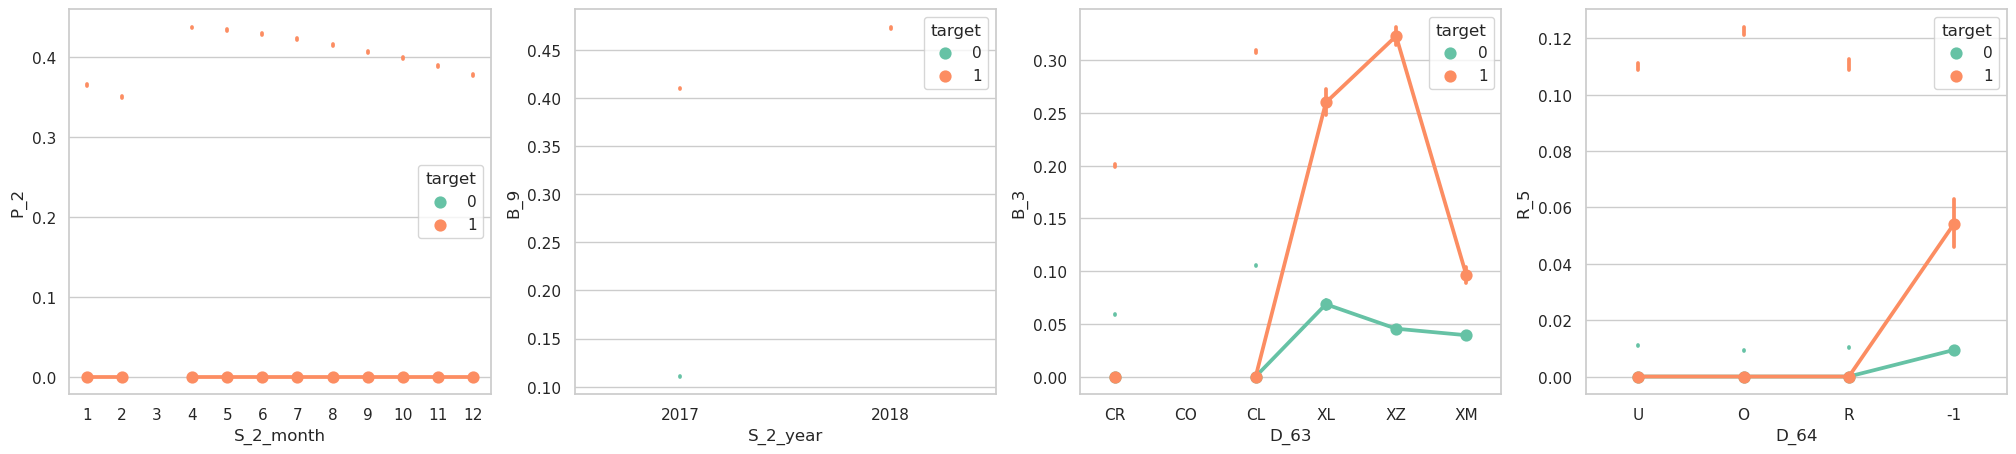

In [46]:
f, ax = plt.subplots(nrows=1, ncols=4,figsize=(25,5))

sns.pointplot(x="S_2_month", y="P_2", hue="target",
                   data=train_df, palette="Set2", ax=ax[0])
sns.pointplot(x="S_2_year", y="B_9", hue="target",
                   data=train_df, palette="Set2", ax=ax[1])
sns.pointplot(x="D_63", y="B_3", hue="target",
                   data=train_df, palette="Set2", ax=ax[2])
sns.pointplot(x="D_64", y="R_5", hue="target",
                   data=train_df, palette="Set2", ax=ax[3])
plt.show()

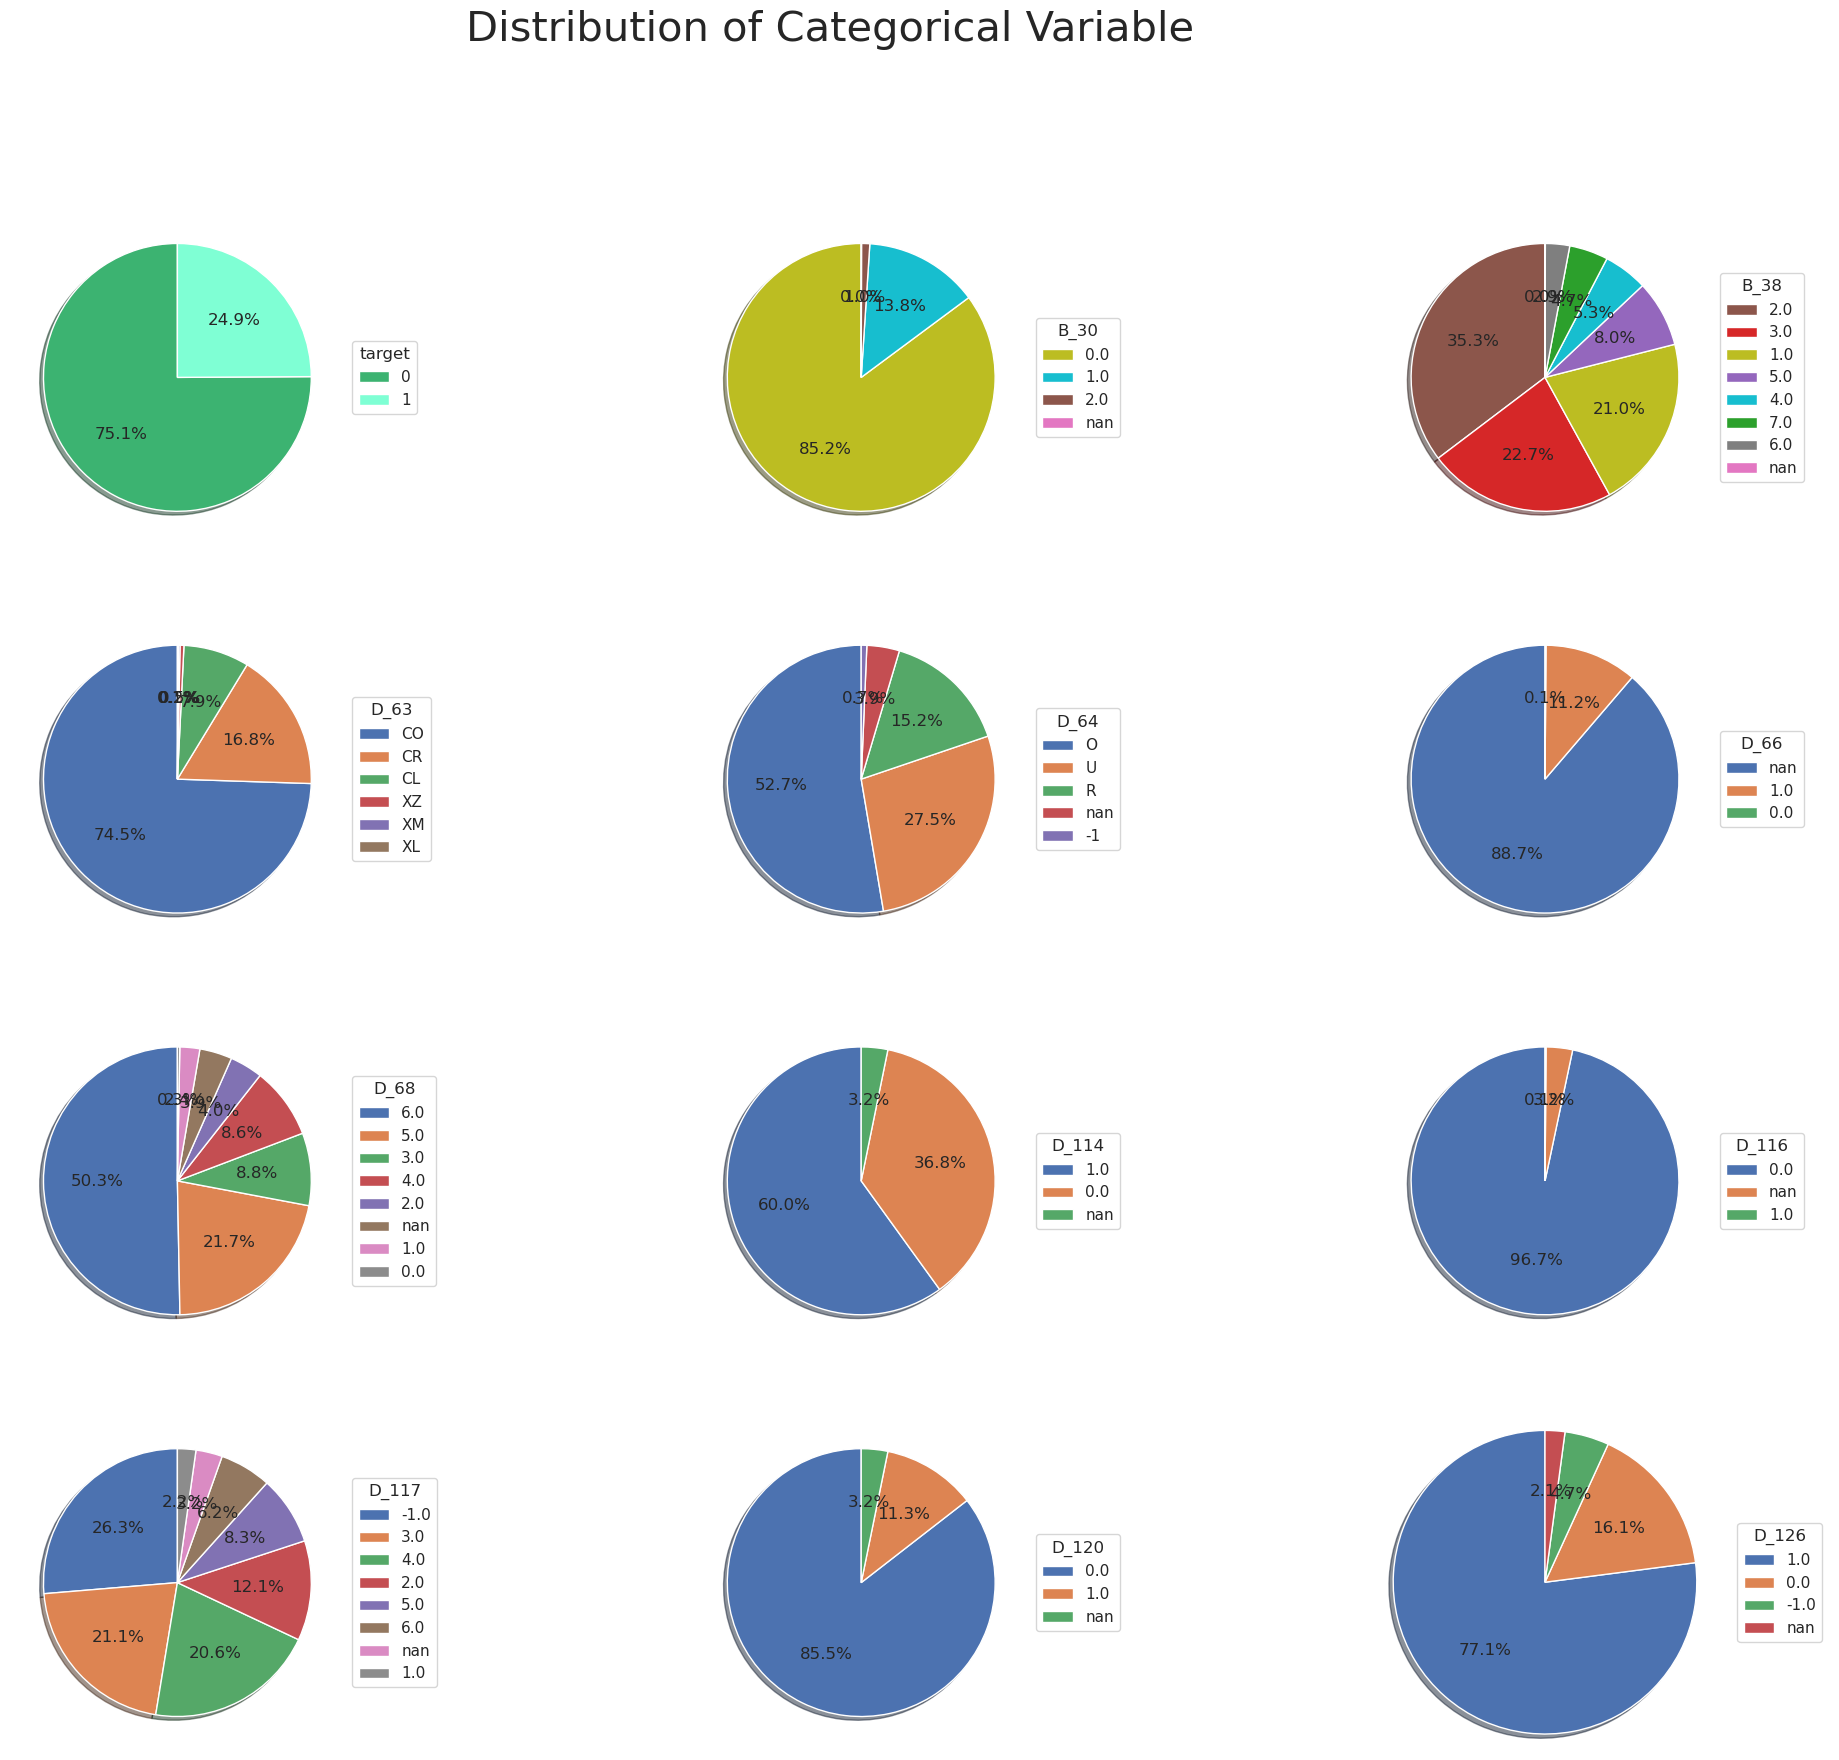

In [49]:
# plot distribution of categorical variables
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12)) = plt.subplots(4,3,figsize=(25,20))
fig.suptitle('Distribution of Categorical Variable',fontsize=30)

ax1.pie(train_df['target'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90, colors={'aquamarine','mediumseagreen'})
ax1.legend(labels = train_df['target'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='target',frameon = True)

ax2.pie(train_df['B_30'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90, colors={'tab:cyan','tab:olive','tab:pink','tab:brown'})
ax2.legend(labels = train_df['B_30'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='B_30',frameon = True)

ax3.pie(train_df['B_38'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90,colors={'tab:cyan','tab:olive','tab:pink','tab:brown','tab:gray','tab:purple','tab:red','tab:green'})
ax3.legend(labels = train_df['B_38'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='B_38',frameon = True)

ax4.pie(train_df['D_63'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90)
ax4.legend(labels = train_df['D_63'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5),title ='D_63',frameon = True)

ax5.pie(train_df['D_64'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90)
ax5.legend(labels = train_df['D_64'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_64',frameon = True)

ax6.pie(train_df['D_66'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90)
ax6.legend(labels = train_df['D_66'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_66',frameon = True)

ax7.pie(train_df['D_68'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90)
ax7.legend(labels = train_df['D_68'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_68',frameon = True)

ax8.pie(train_df['D_114'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90)
ax8.legend(labels = train_df['D_114'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_114',frameon = True)

ax9.pie(train_df['D_116'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90)
ax9.legend(labels = train_df['D_116'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_116',frameon = True)

ax10.pie(train_df['D_117'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90)
ax10.legend(labels = train_df['D_117'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_117',frameon = True)

ax11.pie(train_df['D_120'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90)
ax11.legend(labels = train_df['D_120'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_120',frameon = True)

ax12.pie(train_df['D_126'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90)
ax12.legend(labels = train_df['D_126'].value_counts(dropna=False).index, loc ='center right', title ='D_126',frameon = True)

plt.axis('equal')
fig.show()

## Correlations all variables


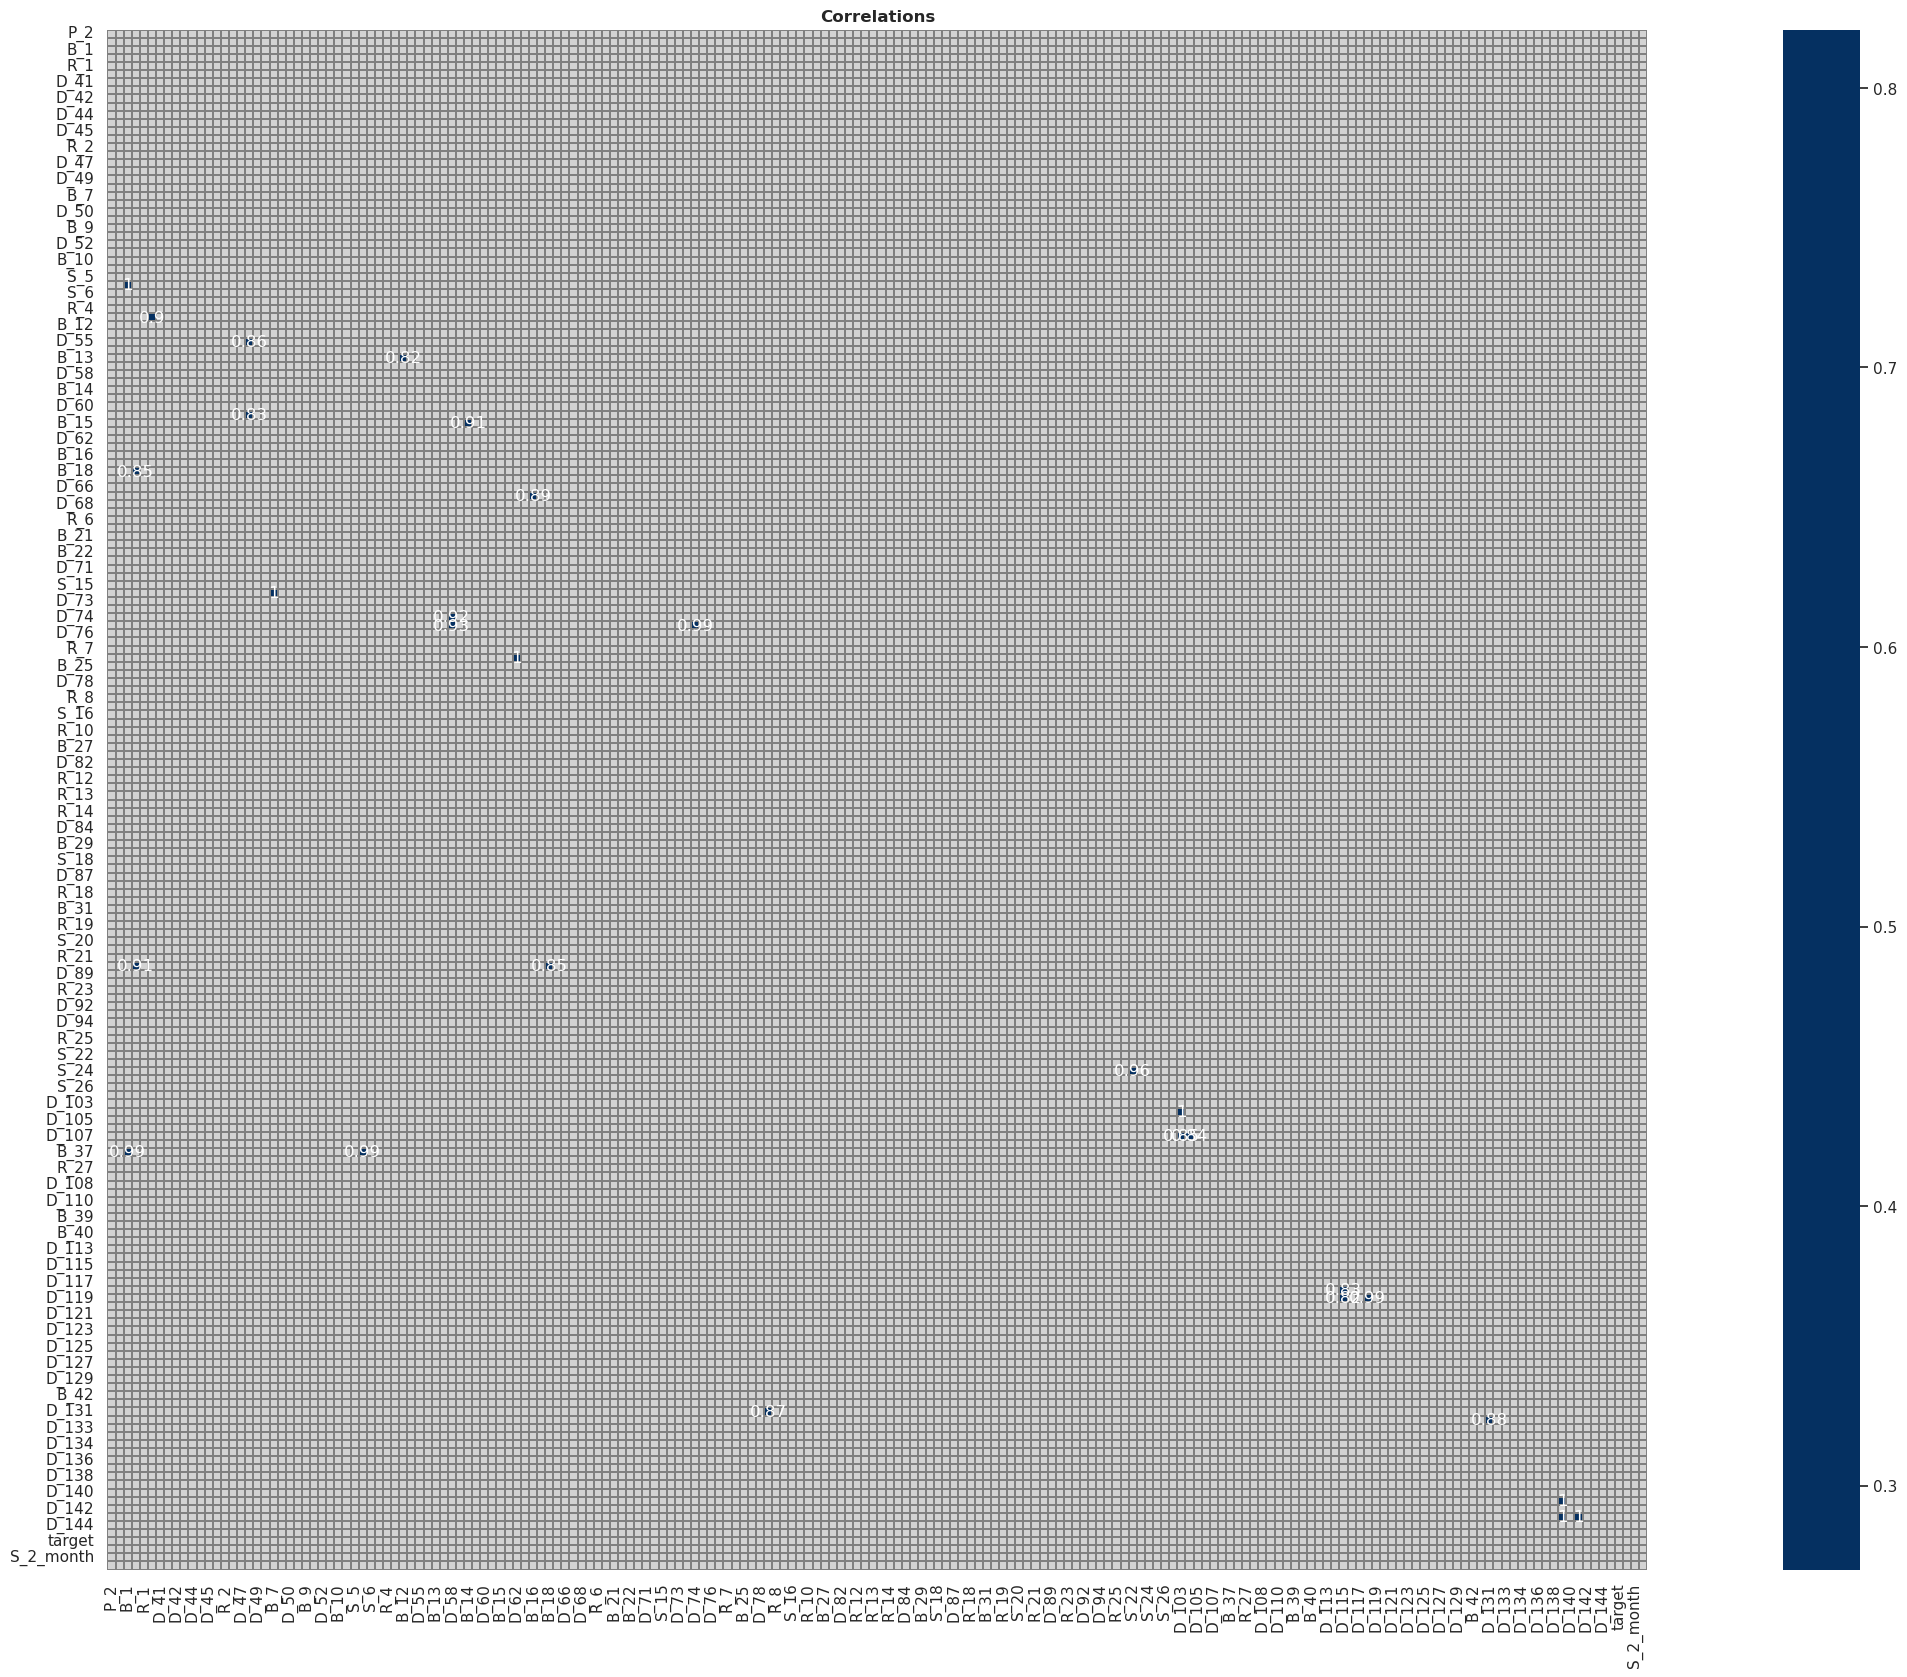

In [50]:
corrs = train_df.corr()
corrs = corrs[corrs>=.8]
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(35, 20))
    ax.set_title('Correlations', fontsize=12, fontweight="bold")
    ax.set_facecolor('lightgrey')
    ax = sns.heatmap(corrs, mask=mask, vmax=.3, square=True, annot=True, linewidth=0.1, center=0, cmap="RdBu", linecolor='grey')
# end with
plt.show()

In [51]:
feat_Delinquency = [c for c in train_df.columns if c.startswith('D_')]
feat_Spend = [c for c in train_df.columns if c.startswith('S_')]
feat_Payment = [c for c in train_df.columns if c.startswith('P_')]
feat_Balance = [c for c in train_df.columns if c.startswith('B_')]
feat_Risk = [c for c in train_df.columns if c.startswith('R_')]
print(f'Total number of Delinquency variables: {len(feat_Delinquency)}')
print(f'Total number of Spend variables: {len(feat_Spend)}')
print(f'Total number of Payment variables: {len(feat_Payment)}')
print(f'Total number of Balance variables: {len(feat_Balance)}')
print(f'Total number of Risk variables: {len(feat_Risk)}')

Total number of Delinquency variables: 96
Total number of Spend variables: 25
Total number of Payment variables: 3
Total number of Balance variables: 40
Total number of Risk variables: 28


In [52]:
del_cols = [c for c in train_df.columns if (c.startswith(('D','t'))) & (c not in cat_cols)]
df_del = train_df[del_cols]
spd_cols = [c for c in train_df.columns if (c.startswith(('S','t'))) & (c not in cat_cols)]
df_spd = train_df[spd_cols]
pay_cols = [c for c in train_df.columns if (c.startswith(('P','t'))) & (c not in cat_cols)]
df_pay = train_df[pay_cols]
bal_cols = [c for c in train_df.columns if (c.startswith(('B','t'))) & (c not in cat_cols)]
df_bal = train_df[bal_cols]
ris_cols = [c for c in train_df.columns if (c.startswith(('R','t'))) & (c not in cat_cols)]
df_ris = train_df[ris_cols]

## Delinquency variables


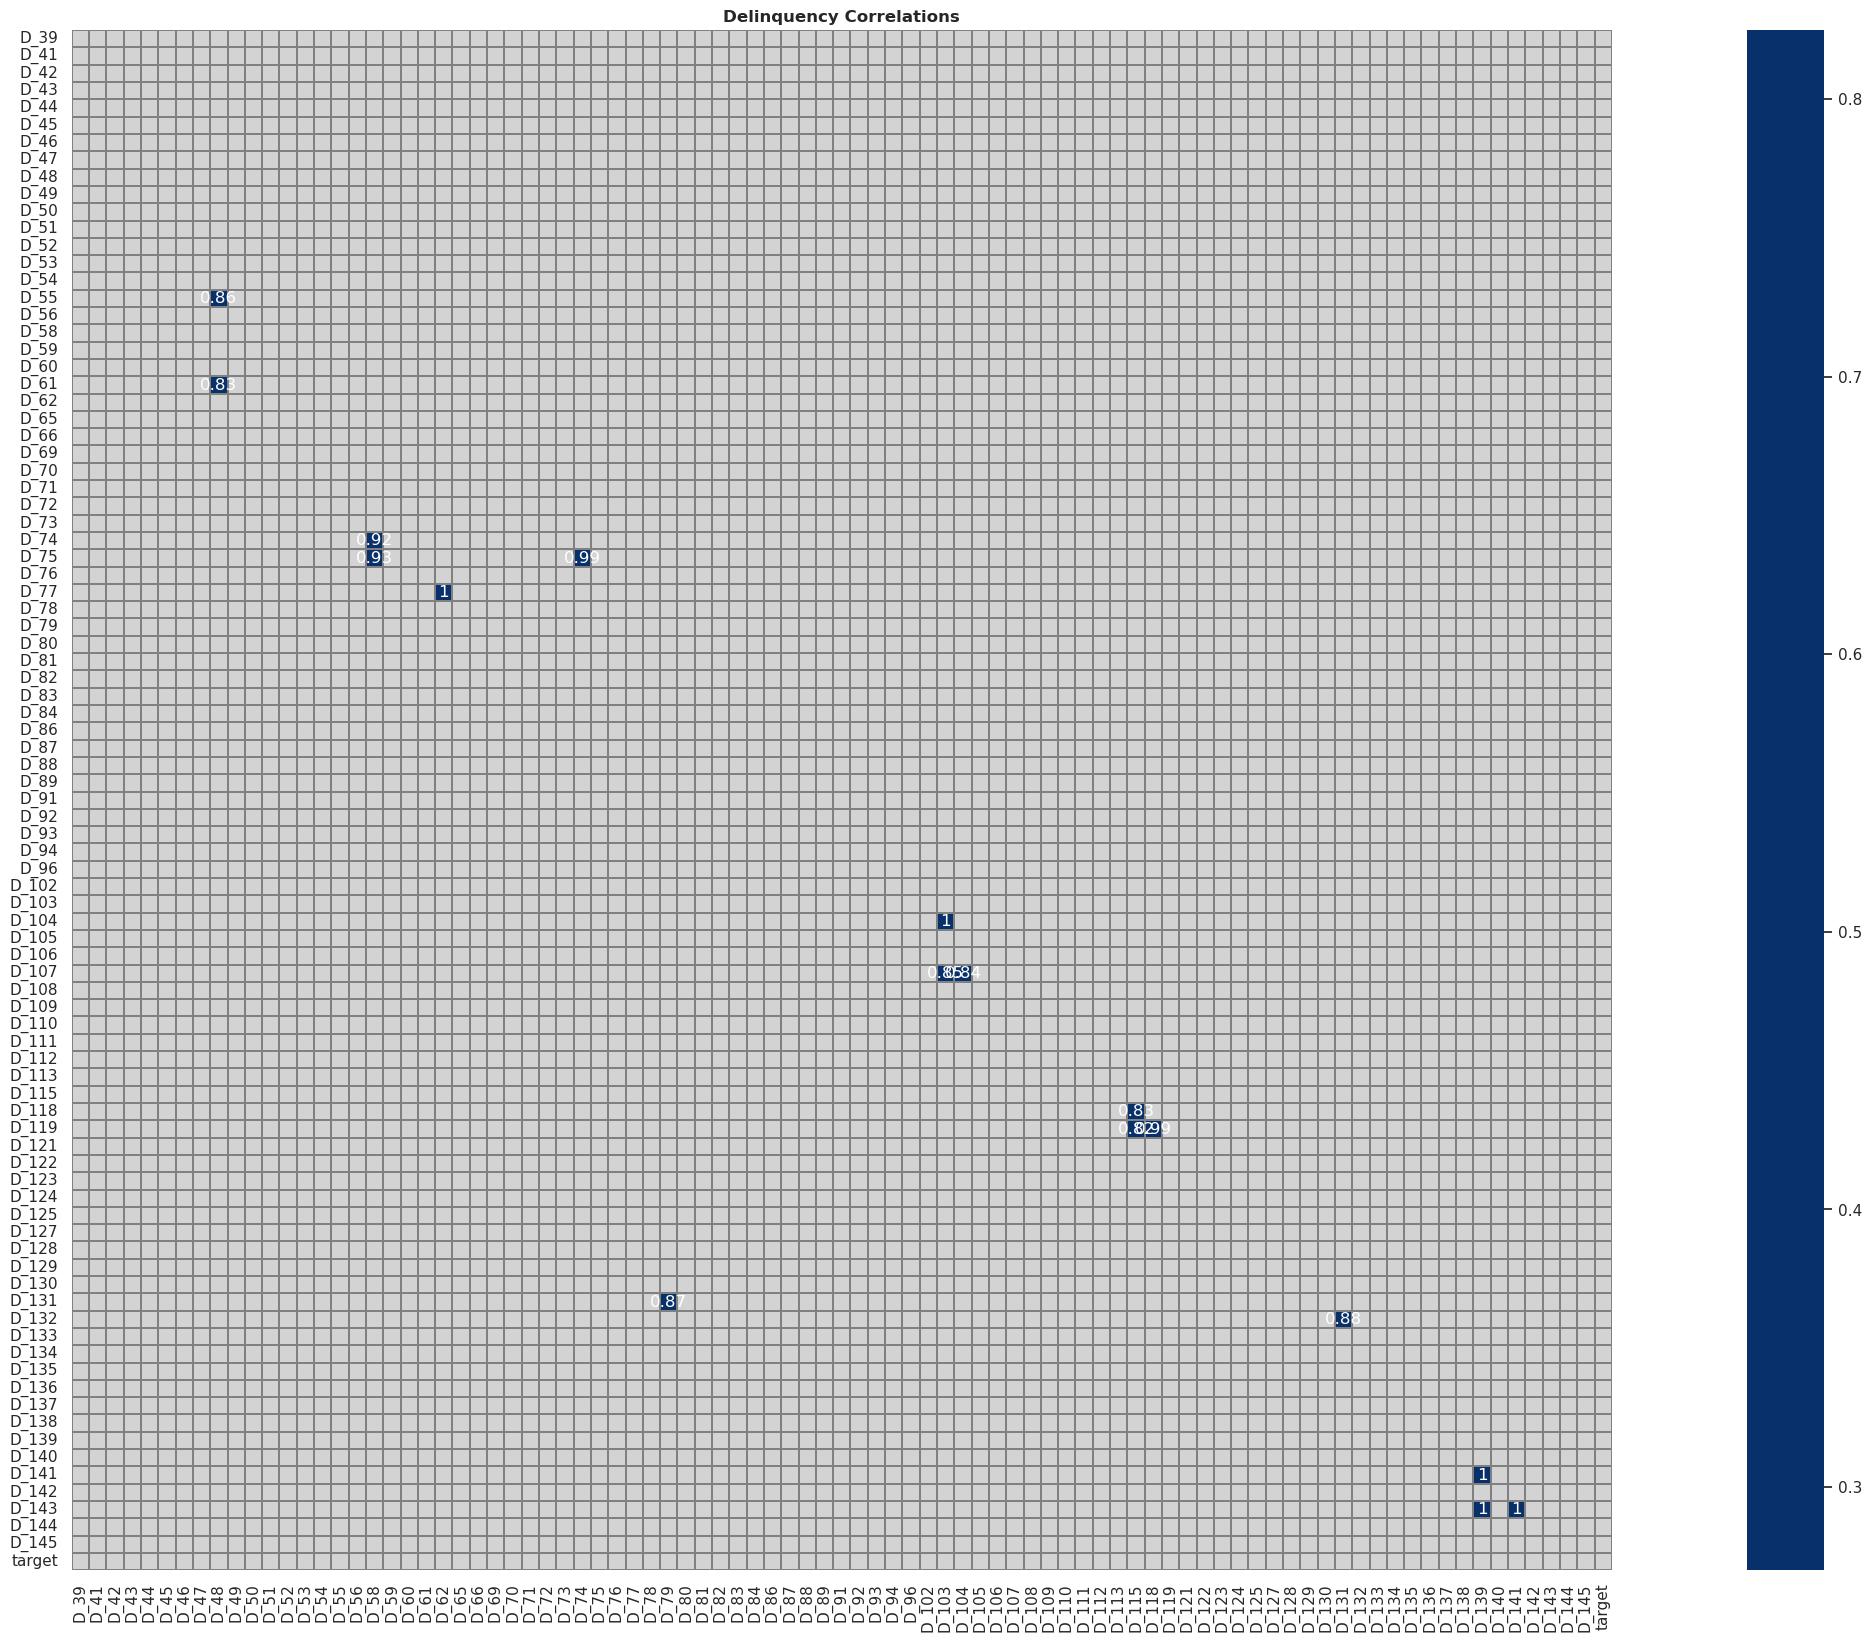

In [53]:
corrs = df_del.corr()
corrs = corrs[corrs>=.8]
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(35, 20))
    ax.set_title('Delinquency Correlations', fontsize=12, fontweight="bold")
    ax.set_facecolor('lightgrey')
    ax = sns.heatmap(corrs, mask=mask, vmax=.3, square=True, annot=True, linewidth=0.1, center=0, cmap="Blues", linecolor='grey')
# end with
plt.show()

## Balance variables


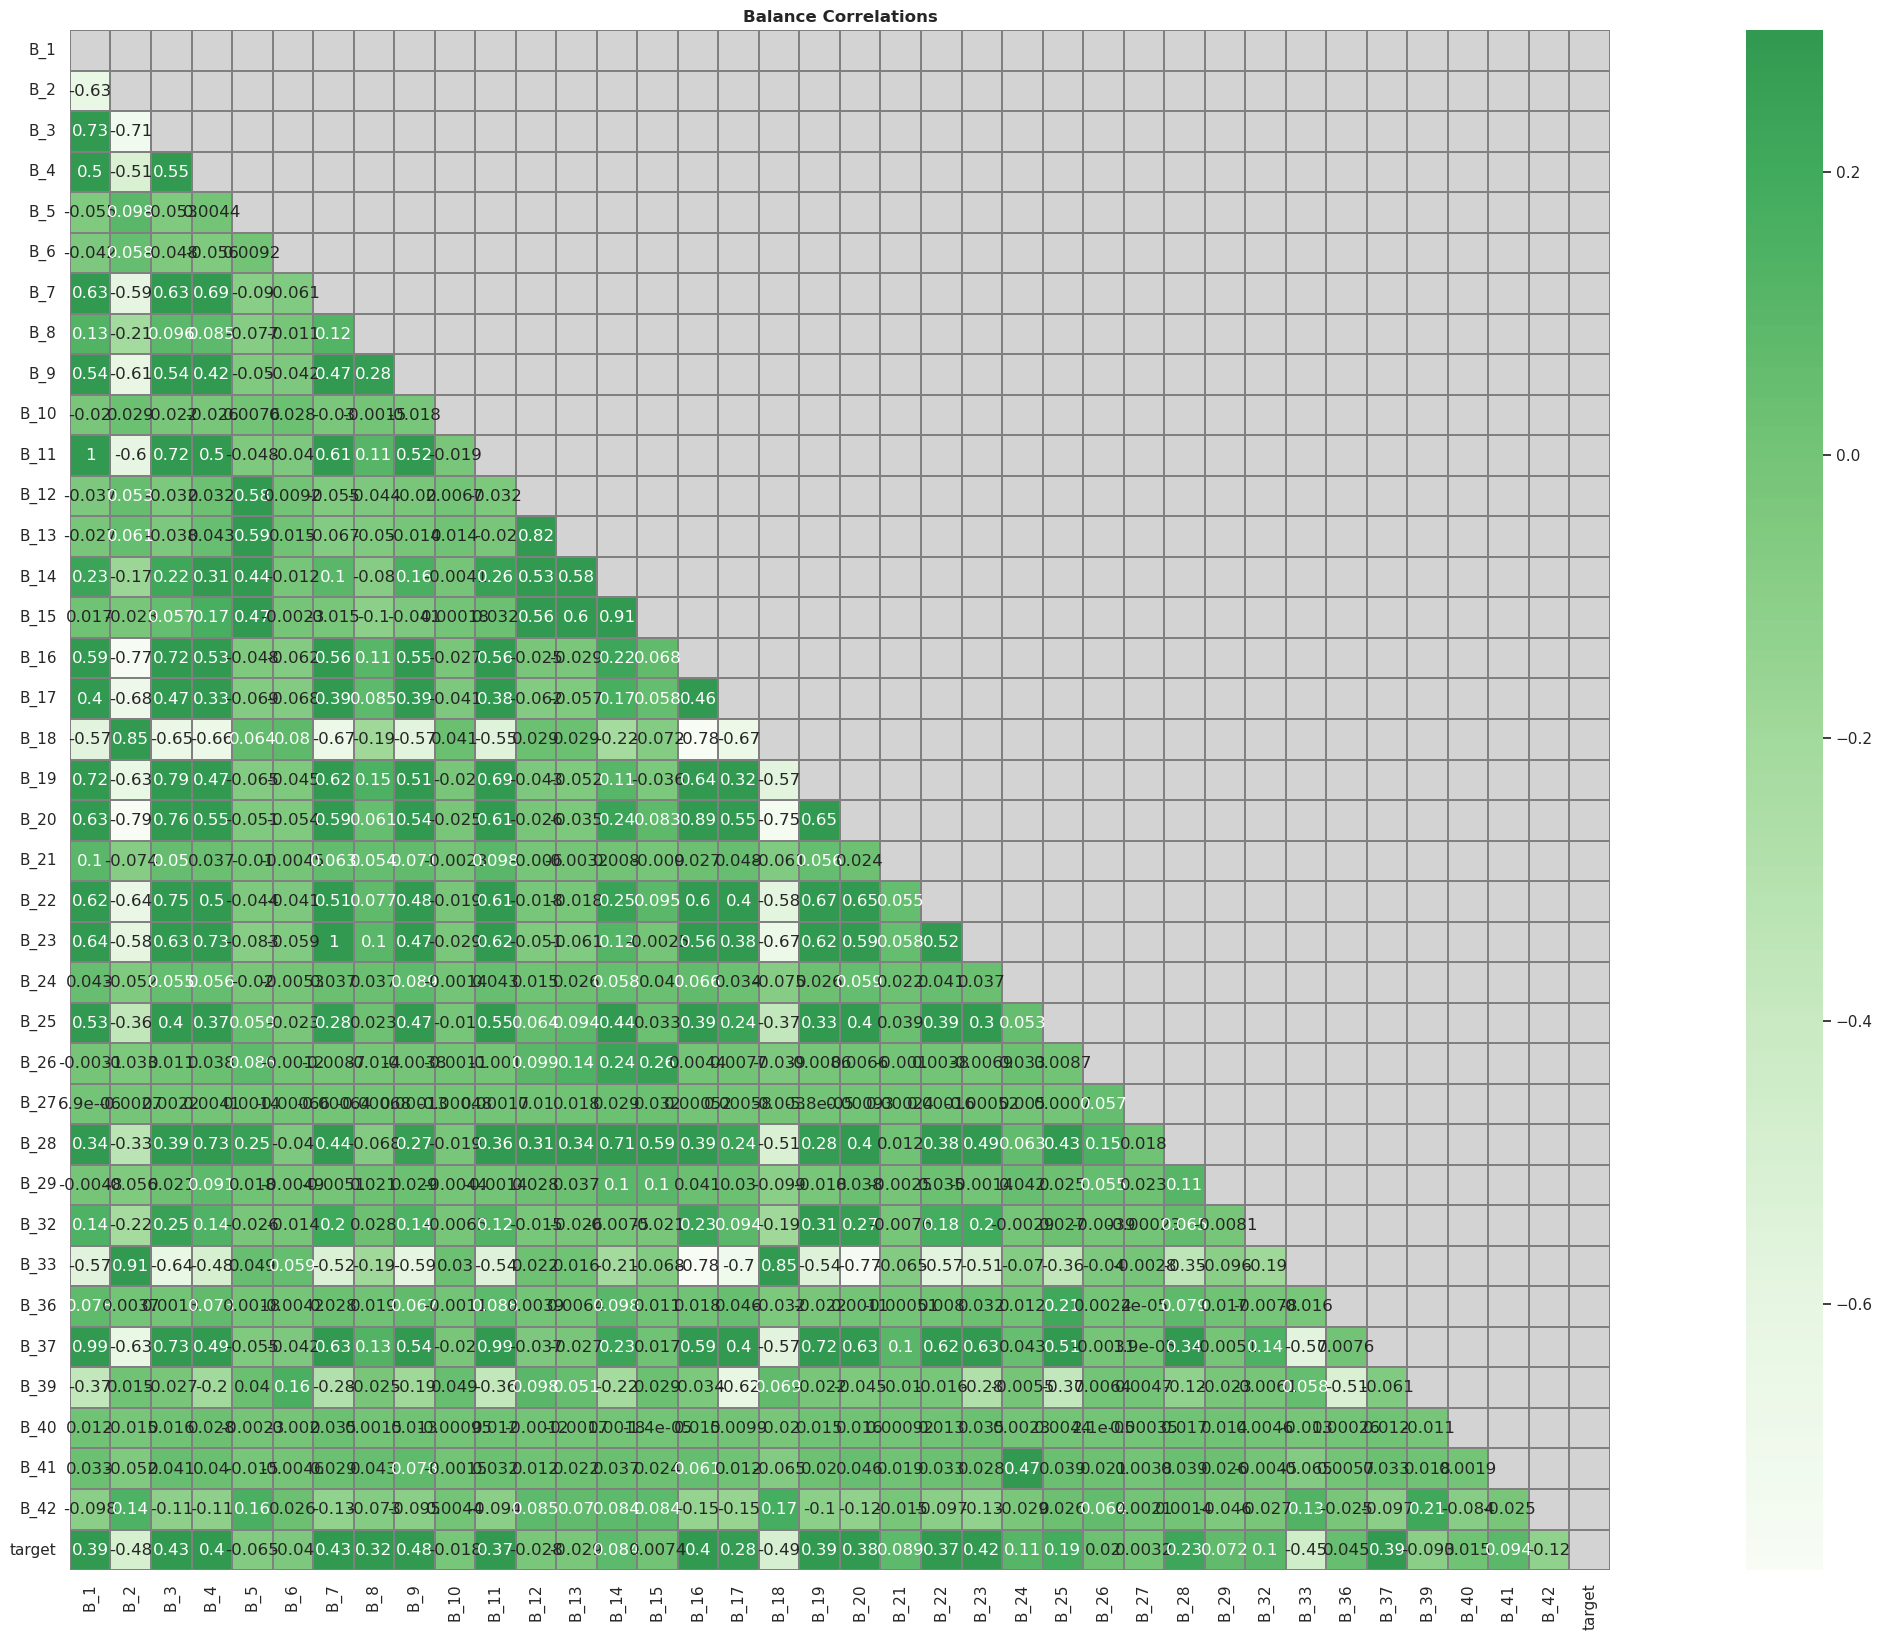

In [55]:
corrs = df_bal.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(35, 20))
    ax.set_title('Balance Correlations', fontsize=12, fontweight="bold")
    ax.set_facecolor('lightgrey')
    ax = sns.heatmap(corrs, mask=mask, vmax=.3, square=True, annot=True, linewidth=0.1, center=0, cmap="Greens", linecolor='grey')
# end with
plt.show()

## Spend variables


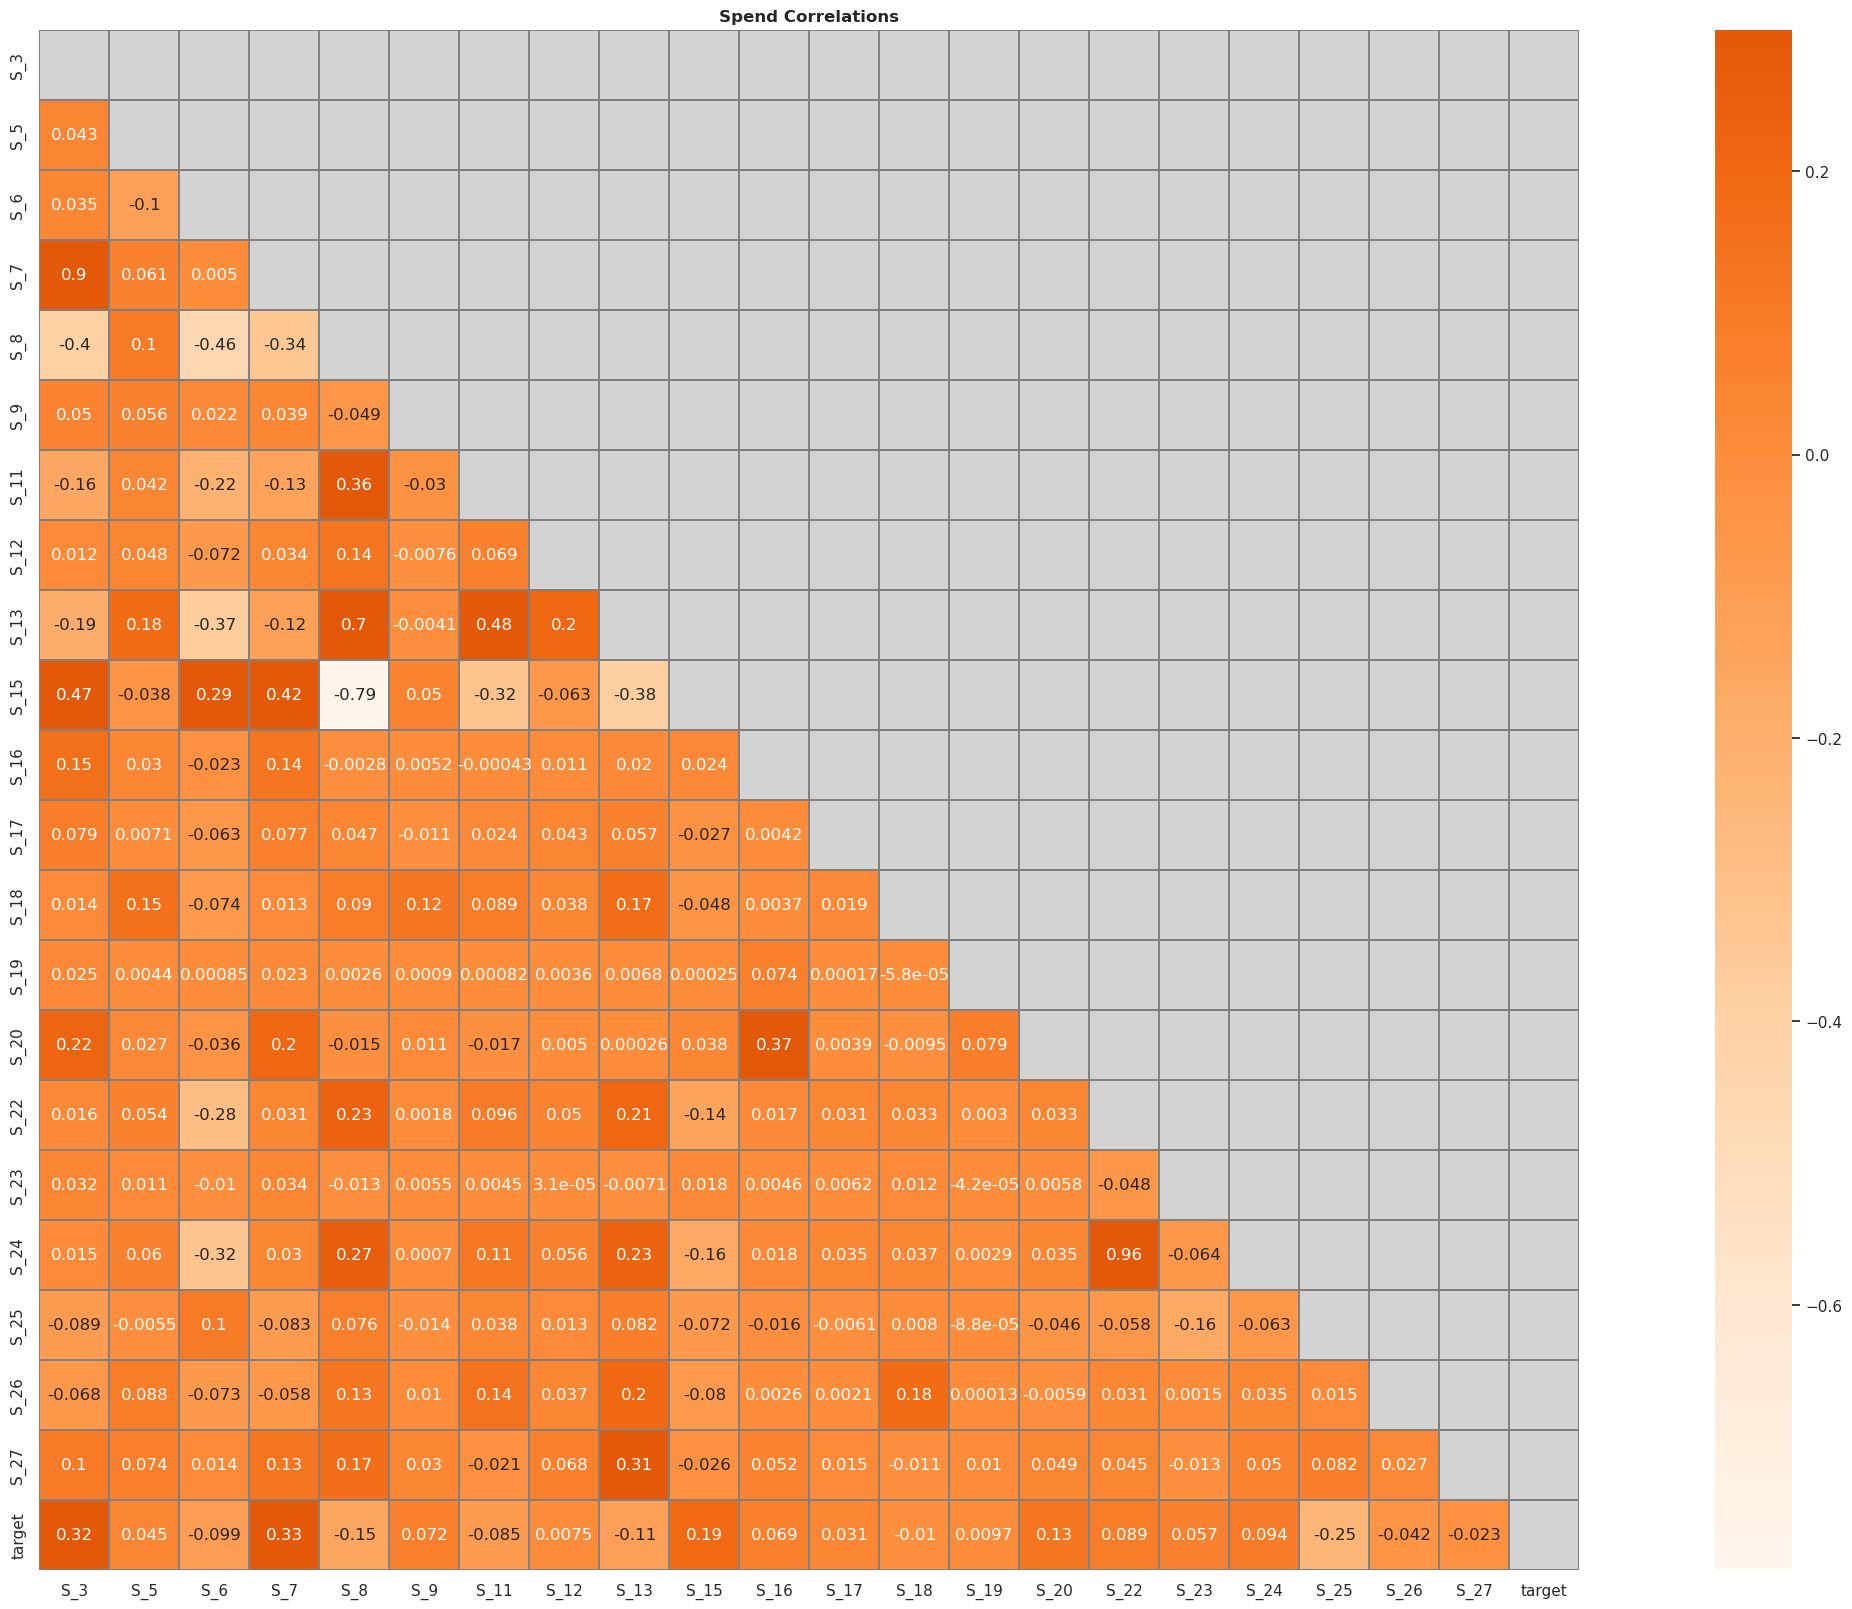

In [57]:
corrs = df_spd.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(35, 20))
    ax.set_title('Spend Correlations', fontsize=12, fontweight="bold")
    ax.set_facecolor('lightgrey')
    ax = sns.heatmap(corrs, mask=mask, vmax=.3, square=True, annot=True, linewidth=0.1, center=0, cmap="Oranges", linecolor='grey')
# end with
plt.show()

## Risk variables

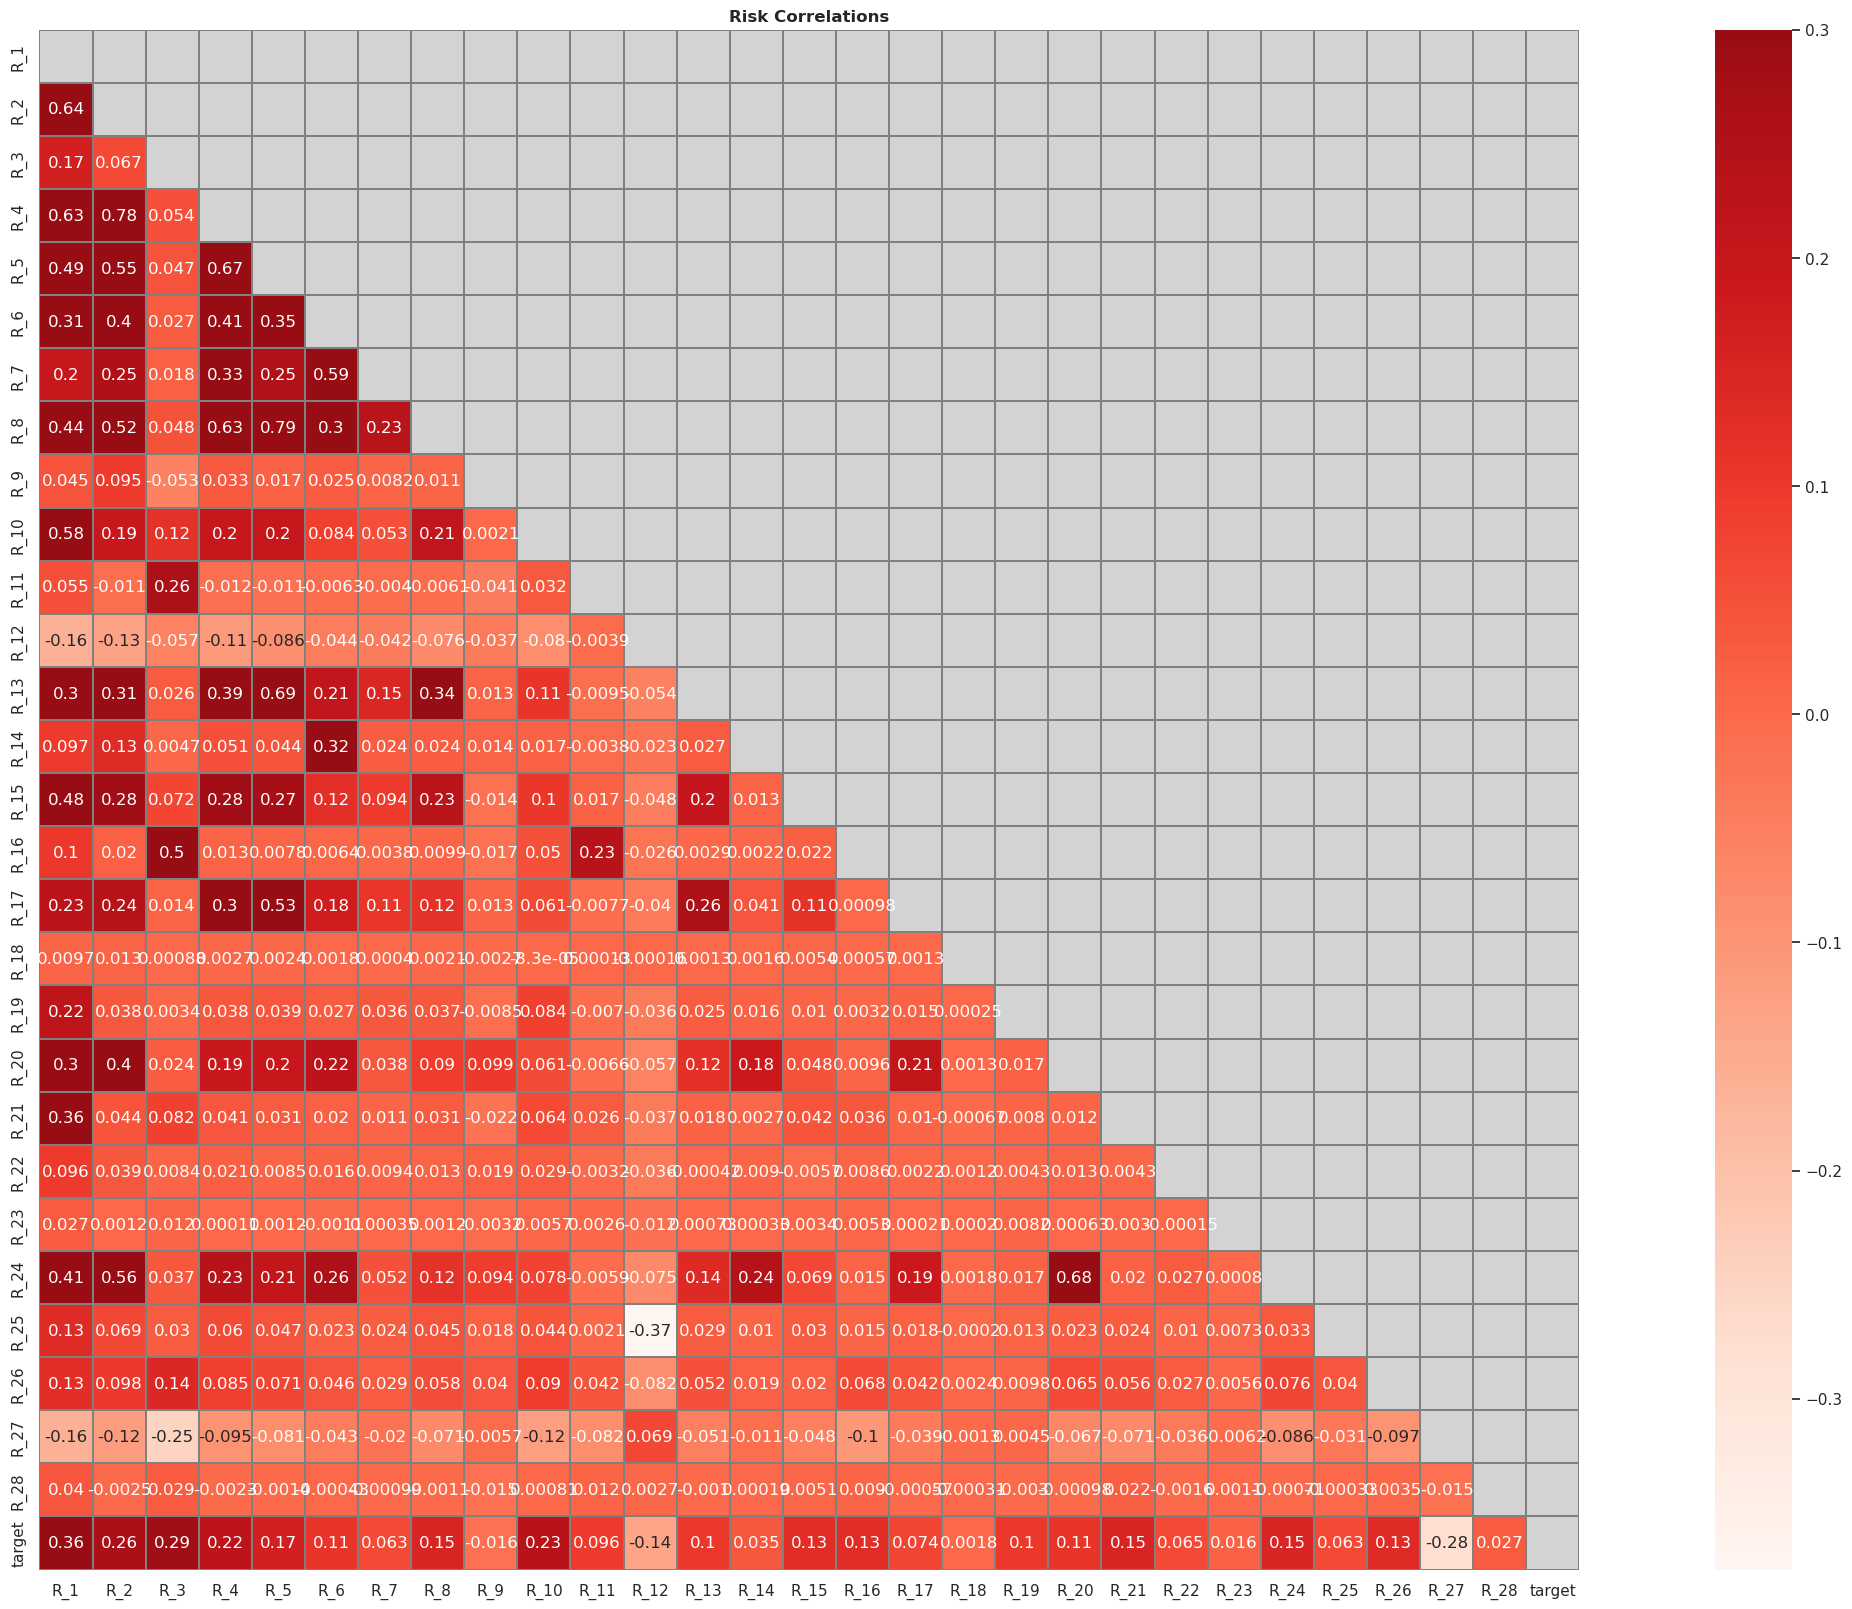

In [59]:
corrs = df_ris.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(35, 20))
    ax.set_title('Risk Correlations', fontsize=12, fontweight="bold")
    ax.set_facecolor('lightgrey')
    ax = sns.heatmap(corrs, mask=mask, vmax=.3, square=True, annot=True, linewidth=0.1, center=0, cmap="Reds", linecolor='grey')
# end with
plt.show()

## Payment variables


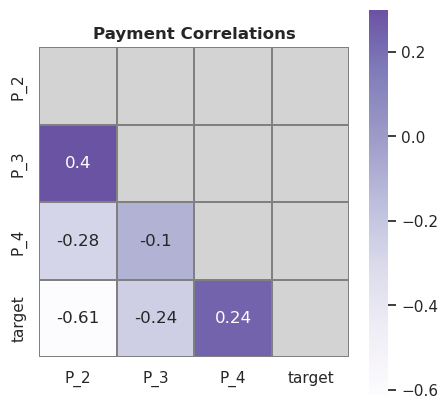

In [63]:
corrs = df_pay.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(5, 5))
    ax.set_title('Payment Correlations', fontsize=12, fontweight="bold")
    ax.set_facecolor('lightgrey')
    ax = sns.heatmap(corrs, mask=mask, vmax=.3, square=True, annot=True, linewidth=0.1, center=0, cmap="Purples", linecolor='grey')
# end with
plt.show()